# Import Modules & Util Functions

In [14]:
import os
import sys
import glob
import re
import ast
import warnings

import csv
import json
import pickle

import math
import random
import numpy as np
import scipy as sp
import datetime as dt
import pandas as pd
import swifter
from scipy.stats import gaussian_kde
from scipy.integrate import quad
from sklearn.metrics import mean_squared_error

import portion as P
import itertools as it
import copy
from tqdm.notebook import tqdm
from collections import namedtuple
from pprint import pprint
from pytictoc import TicToc

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Configure display options
# pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
%config InlineBackend.figure_format = 'retina'

# Set plot style
# plt.style.use('ggplot')


def data_loader(
    mode='sr', query_dates=False, show_info=False,
    selected_dates=[], selected_exps=[], selected_routes=[],
    excluded_dates=[], excluded_exps=[], excluded_routes=[],
    root_dir='/Users/jackbedford/Desktop/MOXA/Code/data'):
    
    # Collect experiment dates
    dates = [s for s in sorted(os.listdir(root_dir)) if os.path.isdir(os.path.join(root_dir, s)) and s not in ['backup']]
    
    if query_dates:
        if show_info:
            date_dirs = [os.path.join(root_dir, s) for s in dates]
            for date, date_dir in zip(dates, date_dirs):
                date = os.path.basename(date_dir)
                
                # Specify path to JSON file
                json_filepath = os.path.join(date_dir, f'{date}.json')
                
                # Read the JSON file and load its contents into a dictionary
                with open(json_filepath, 'r', encoding='utf-8') as json_file:
                    my_dict = json.load(json_file)
                
                # If the JSON file is empty, then continue
                if not my_dict:
                    continue
                
                print(date, len(my_dict))
                for exp, item in my_dict.items():
                    print({exp: item})
                
        return dates
    
    # Collect experiments
    date_dirs = [os.path.join(root_dir, s) for s in selected_dates if s not in excluded_dates]
    exps_dict = {}
    
    for date_dir in date_dirs:
        date = os.path.basename(date_dir)
                
        # Specify path to JSON file
        json_filepath = os.path.join(date_dir, f'{date}.json')
        
        # Read the JSON file and load its contents into a dictionary
        with open(json_filepath, 'r', encoding='utf-8') as json_file:
            my_dict = json.load(json_file)
        
        # If the JSON file is empty, then continue
        if not my_dict:
            continue
        
        for i, (exp, item) in enumerate(my_dict.items()):
            if len(selected_exps) != 0 and exp not in selected_exps:
                continue
            if len(excluded_exps) != 0 and exp in excluded_exps:
                continue
            if len(selected_routes) != 0 and item['route'] not in selected_routes:
                continue
            if len(excluded_routes) != 0 and item['route'] in excluded_routes:
                continue
            try:
                exps_dict[date] = {**exps_dict[date], **{exp: item}}
            except:
                exps_dict[date] = {exp: item}
    
    if show_info:            
        for date, exps in exps_dict.items():
            print(date, len(exps))
            for exp_name, exp in exps.items():
                print({exp_name: exp})
    
    filepaths = []
    if mode == 'sr':
        for date, exps in exps_dict.items():
            # print(date, len(exps))
            
            for exp_name, exp in exps.items():
                exp_dir = os.path.join(root_dir, date, exp_name)
                # print({exp_name: exp})
                
                devices = list(exp['devices'].keys())
                trips = ['#{:02d}'.format(s[0]) for s in exp['ods'][1:]]
                for trip in trips:
                    for dev in devices:
                        data_dir = os.path.join(exp_dir, dev, trip, 'data')
                        filepaths.append([
                            os.path.join(data_dir, 'handover_info_log.csv'),
                            os.path.join(data_dir, 'udp_dnlk_loss_latency.csv'),
                            os.path.join(data_dir, 'udp_uplk_loss_latency.csv'),
                            os.path.join(data_dir, [s for s in os.listdir(data_dir) if s.endswith('rrc.csv')][0]),
                            os.path.join(data_dir, [s for s in os.listdir(data_dir) if s.endswith('ml1.csv') and not s.endswith('nr_ml1.csv')][0]),
                            os.path.join(data_dir, [s for s in os.listdir(data_dir) if s.endswith('nr_ml1.csv')][0]),
                            ])
    elif mode == 'dr':
        for date, exps in exps_dict.items():
            # print(date, len(exps))
            
            for exp_name, exp in exps.items():
                exp_dir = os.path.join(root_dir, date, exp_name)
                # print({exp_name: exp})
                
                devices = list(exp['devices'].keys())
                combos = list(it.combinations(devices, 2))
                trips = ['#{:02d}'.format(s[0]) for s in exp['ods'][1:]]
                for trip in trips:
                    for dev1, dev2 in combos:
                        data_dir1 = os.path.join(exp_dir, dev1, trip, 'data')
                        data_dir2 = os.path.join(exp_dir, dev2, trip, 'data')
                        _filepaths = []
                        for i in range(2):
                            _filepaths.append([
                                os.path.join(locals()[f'data_dir{i+1}'], 'handover_info_log.csv'),
                                os.path.join(locals()[f'data_dir{i+1}'], 'udp_dnlk_loss_latency.csv'),
                                os.path.join(locals()[f'data_dir{i+1}'], 'udp_uplk_loss_latency.csv'),
                                os.path.join(locals()[f'data_dir{i+1}'], [s for s in os.listdir(locals()[f'data_dir{i+1}']) if s.endswith('rrc.csv')][0]),
                                os.path.join(locals()[f'data_dir{i+1}'], [s for s in os.listdir(locals()[f'data_dir{i+1}']) if s.endswith('ml1.csv') and not s.endswith('nr_ml1.csv')][0]),
                                os.path.join(locals()[f'data_dir{i+1}'], [s for s in os.listdir(locals()[f'data_dir{i+1}']) if s.endswith('nr_ml1.csv')][0]),
                            ])
                        filepaths.append(tuple(_filepaths))
    return filepaths


def data_aligner(df, ho_df):
    empty_data = False
    
    if df.empty or ho_df.empty:
        empty_data = True
        return df, ho_df, empty_data
    
    start_ts = df.iloc[0]['Timestamp'] - pd.Timedelta(seconds=1)
    end_ts = df.iloc[-1]['Timestamp'] + pd.Timedelta(seconds=1)
    ho_df = ho_df[(ho_df['start'] >= start_ts) & (ho_df['start'] < end_ts)].reset_index(drop=True)
    
    if ho_df.empty:
        empty_data = True
        return df, ho_df, empty_data
    
    start_ts = ho_df.iloc[0]['start'] - pd.Timedelta(seconds=100)
    end_ts = ho_df.iloc[-1]['start'] + pd.Timedelta(seconds=100)
    df = df[(df['Timestamp'] >= start_ts) & (df['Timestamp'] < end_ts)].reset_index(drop=True)
    
    return df, ho_df, empty_data


def data_consolidator(df1, df2, ho_df1, ho_df2):
    empty_data = False
    
    df1, ho_df1, empty_data1 = data_aligner(df1, ho_df1)
    df2, ho_df2, empty_data2 = data_aligner(df2, ho_df2)
    if empty_data1 or empty_data2:
        empty_data = True
        return None, df1, df2, ho_df1, ho_df2, empty_data
    
    df = pd.merge(df1, df2, on='seq', how='inner').reset_index(drop=True)
    df1 = df[['seq', 'Timestamp_x', 'lost_x', 'excl_x', 'latency_x']].rename(columns={'Timestamp_x': 'Timestamp', 'lost_x': 'lost', 'excl_x': 'excl', 'latency_x': 'latency'})
    df2 = df[['seq', 'Timestamp_y', 'lost_y', 'excl_y', 'latency_y']].rename(columns={'Timestamp_y': 'Timestamp', 'lost_y': 'lost', 'excl_y': 'excl', 'latency_y': 'latency'})
    df1, ho_df1, _ = data_aligner(df1, ho_df1)
    df2, ho_df2, _ = data_aligner(df2, ho_df2)
    
    return df, df1, df2, ho_df1, ho_df2, empty_data

# Demo: Select & Read Data From Database

In [3]:
# # Single Radio Example
# dates = data_loader(query_dates=True)

# selected_dates = [s for s in dates if s >= '2023-09-12']
# # excluded_dates = []
# # selected_exps = []
# # excluded_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
# # selected_routes = ['BR']
# # excluded_routes = []
# filepaths = data_loader(mode='sr', selected_dates=selected_dates)

# filepath = filepaths[0]
# pprint(filepath)

# ho_df = pd.read_csv(filepath[0], parse_dates=['start', 'end'])
# df = pd.read_csv(filepath[1], parse_dates=['Timestamp'])[['seq', 'Timestamp', 'lost', 'excl', 'latency']]
# df, ho_df, empty_data = data_aligner(df, ho_df)

# display(df)

In [4]:
# # Dual Radio Example
# dates = data_loader(query_dates=True)

# selected_dates = [s for s in dates if s >= '2023-09-12']
# # excluded_dates = []
# # selected_exps = []
# # excluded_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
# # selected_routes = ['BR']
# # excluded_routes = []
# filepaths = data_loader(mode='dr', selected_dates=selected_dates)

# filepath = filepaths[0]
# pprint(filepath)

# ho_df1 = pd.read_csv(filepath[0][0], parse_dates=['start', 'end'])
# ho_df2 = pd.read_csv(filepath[1][0], parse_dates=['start', 'end'])
# df1 = pd.read_csv(filepath[0][1], parse_dates=['Timestamp'])[['seq', 'Timestamp', 'lost', 'excl', 'latency']]
# df2 = pd.read_csv(filepath[1][1], parse_dates=['Timestamp'])[['seq', 'Timestamp', 'lost', 'excl', 'latency']]
# df, df1, df2, ho_df1, ho_df2, empty_data = data_consolidator(df1, df2, ho_df1, ho_df2)

# display(df)

# Single Radio Profiling

In [5]:
class Profile():
    def __init__(self, filepaths, model_name='Trial',
                 scope_agg=None, scope=None, sp_columns=['type'], ts_column='Timestamp',
                 metrics=['dl_lost', 'dl_excl', 'ul_lost', 'ul_excl']):
        
        # Initialize instance variables
        self.filepaths = copy.deepcopy(filepaths)
        self.model_name = model_name
        if scope_agg is None:
            if scope is None:
                scope = {
                    **{key: (-5.0, 5.0) for key in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II']},
                    **{key: (-10.0, 10.0) for key in ['SCGF', 'MCGF', 'NASR']}, 
                    'Stable': (-1.0, 1.0)
                }
            self.scope_agg = { mode_mets: scope.copy() for mode_mets in metrics }   
        else:
            self.scope_agg = copy.deepcopy(scope_agg)
        self.sp_columns = sp_columns[:]
        self.ts_column = ts_column
        self.metrics = metrics[:]
        self.Container = { mode_mets: { tag: { 'dist_table': [],
                                               'relative_loex_timestamp': [],
                                               'relative_timestamp': [],
                                               'interruption_time': [],
                                               'trigger_loex': [],
                                               'event_count': [] } 
                                        for tag in self.scope_agg[mode_mets].keys() }
                                        for mode_mets in metrics }
        self.Profile = { mode_mets: { tag: { 'dist_table': None,
                                             'relative_loex_timestamp': [],
                                             'relative_timestamp': [],
                                             'interruption_time': [],
                                             'trigger_loex': [],
                                             'event_count': 0 } 
                                        for tag in self.scope_agg[mode_mets].keys() }
                                        for mode_mets in metrics }
        self.scope_models = copy.deepcopy(self.scope_agg)
        self.hist_models = { mode_mets: { tag: None for tag in self.scope_agg[mode_mets].keys() } for mode_mets in metrics }
        self.kde_models = { mode_mets: { tag: (None, None) for tag in self.scope_agg[mode_mets].keys() } for mode_mets in metrics }
        self.prob_models = { mode_mets: { tag: None for tag in self.scope_agg[mode_mets].keys() } for mode_mets in metrics }
        
        # Construct profiles
        self.construct_profile()
        self.modeling()
    
    
    @staticmethod
    def interpolate(x, y, ratio=0.5):
        """
        Args:
            x, y (datetime.datetime): x < y
            ratio (float): a decimal numeral in a range [0, 1]; 0 means break at x, 1 means break at y.
        Returns:
            (datetime.datetime): breakpoint of interpolation
        """
        return x + (y - x) * ratio
    
    
    def create_instance(self, df, center, interval, mets='lost', w_size=0.01):
        df = df[(df[self.ts_column] >= interval.lower) & (df[self.ts_column] < interval.upper)].copy().reset_index(drop=True)
        
        # Relative window converted from timestamp
        df['relative_time'] = (df['Timestamp'] - center).dt.total_seconds()
        df['window_id'] = ((df['relative_time'] + w_size / 2) // w_size) * w_size  # 四捨五入
        
        if mets == 'lost':
            RATE_TYPE = 'PLR'
            loex_df = df[df['lost']].copy()
            ts_group = df.groupby(['window_id'])
            table = ts_group.agg({'lost': ['count','sum'], 'Timestamp': ['first']}).reset_index()
        elif mets == 'excl':
            RATE_TYPE = 'ELR'
            df['excl_exact'] = df['excl'] & ~df['lost']
            loex_df = df[df['excl_exact']].copy()
            ts_group = df.groupby(['window_id'])
            table = ts_group.agg({'excl_exact': ['count','sum'], 'Timestamp': ['first']}).reset_index()
        
        table.columns = ['window_id','tx_count',mets,'Timestamp']
        
        return table, loex_df['relative_time'].to_list(), df['relative_time'].to_list()
        # return table, loex_df['relative_time'].to_numpy()
    
    
    def setup_profile(self, df, ho_df, mode, mets, scope):
        # Initialize "Register"
        Register = { tag: { 'dist_table': [],
                            'relative_loex_timestamp': [],
                            'relative_timestamp': [],
                            'interruption_time': [],
                            'trigger_loex': [] } for tag in scope.keys() }
        this_df = df.copy()
        
        for i, row in ho_df.iterrows():
            prior_row = ho_df.iloc[i-1] if i != 0 else None
            post_row = ho_df.iloc[i+1] if i != len(ho_df) - 1 else None

            # Peek the next event to avoid HO overlapping with handoverFailure (skip!!)
            if i != len(ho_df) - 1 and pd.notna(row.end) and row.end > post_row.start:
                # print('Overlapping event occurs!!')
                # print(i, row['start'], row['end'], row['type'], row['cause'])
                # print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
                continue
            
            # Set prior event if the prior loop is skipped
            if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                prior_row = ho_df.iloc[i-2] if i > 1 else None
            
            # Basic information of the current row
            tag = '_'.join([s for s in row[self.sp_columns] if pd.notna(s)])  # specific column name
            start_ts, end_ts = row['start'], row['end']  # handover start/end time
            interruption_time = (end_ts - start_ts).total_seconds() if pd.notna(end_ts) else 0  # handover interruption time
            
            # Set simple left/right bounds
            current_left_bound = start_ts + pd.Timedelta(seconds=(scope[tag][0]))
            current_right_bound = start_ts + pd.Timedelta(seconds=(scope[tag][1]))
            
            # Set left/right bounds to avoid event overlapping with each other
            if prior_row is not None:
                prior_tag = '_'.join([s for s in prior_row[self.sp_columns] if pd.notna(s)])
                prior_right_bound = prior_row['start'] + pd.Timedelta(seconds=(scope[prior_tag][1]))
                if pd.notna(prior_row['end']):
                    # left = prior_row['end'] + (start_ts - prior_row['end']) / 2
                    left_bound = min(max(current_left_bound, Profile.interpolate(prior_right_bound, current_left_bound), prior_row['end']), start_ts)
                else:
                    # left = prior_row['start'] + (start_ts - prior_row['start']) / 2
                    left_bound = min(max(current_left_bound, Profile.interpolate(prior_right_bound, current_left_bound), prior_row['start']), start_ts)
            else:
                # left_bound = pd.Timestamp.min
                left_bound = current_left_bound
            
            if post_row is not None:
                post_tag = '_'.join([s for s in post_row[self.sp_columns] if pd.notna(s)])
                post_left_bound = post_row['start'] + pd.Timedelta(seconds=(scope[post_tag][0]))
                if pd.notna(end_ts):
                    # right = end_ts + (post_row['start'] - end_ts) / 2
                    right_bound = max(min(current_right_bound, Profile.interpolate(current_right_bound, post_left_bound), post_row['start']), end_ts)
                else:
                    # right = start_ts + (post_row['start'] - start_ts) / 2
                    right_bound = max(min(current_right_bound, Profile.interpolate(current_right_bound, post_left_bound), post_row['start']), start_ts)
            else:
                # right_bound = pd.Timestamp.max
                right_bound = current_right_bound
            
            # interval = P.closed(max(start_ts+pd.Timedelta(seconds=scope[tag][0]), left_bound), min(start_ts+pd.Timedelta(seconds=scope[tag][1]), right_bound))
            interval = P.closed(left_bound, right_bound)

            # Consider the stable duration before an event starts
            stable_df = this_df[this_df[self.ts_column] < interval.lower].copy()
            stable_df['Timestamp_to_second'] = stable_df['Timestamp'].dt.floor('S')
            
            if not stable_df.empty:
                unique_timestamps = stable_df['Timestamp_to_second'].unique()
                
                tmp_df = stable_df.copy()
                for ts in unique_timestamps:
                    stable_center = ts + pd.Timedelta(seconds=0.5)
                    stable_interval = P.closed(ts, min(ts + pd.Timedelta(seconds=1), interval.lower))
                    
                    # Create an instance of stable profile
                    # dist_table, relative_loex_timestamp = self.create_instance(tmp_df.copy(), stable_center, stable_interval, mets=mets)
                    dist_table, relative_loex_timestamp, relative_timestamp = self.create_instance(tmp_df.copy(), stable_center, stable_interval, mets=mets)
                    
                    # if len(relative_loex_timestamp):
                    #     display(dist_table)
                    #     print('Stable', len(relative_loex_timestamp), relative_loex_timestamp)
                    
                    # Feed into "Register"
                    if len(relative_loex_timestamp):
                        Register['Stable']['trigger_loex'].append(1)
                        Register['Stable']['dist_table'].append(dist_table)
                        Register['Stable']['relative_loex_timestamp'] += relative_loex_timestamp
                        # Register['Stable']['relative_loex_timestamp'] = np.concatenate((Register['Stable']['relative_loex_timestamp'], relative_loex_timestamp))
                    else:
                        Register['Stable']['trigger_loex'].append(0)
                    Register['Stable']['interruption_time'].append((stable_interval.upper - stable_interval.lower).total_seconds())
                    Register['Stable']['relative_timestamp'] += relative_timestamp
                    
                    # Update dataframe to accelerate
                    tmp_df = tmp_df[tmp_df[self.ts_column] >= ts + pd.Timedelta(seconds=1)]
            
            # Create an instance of handover profile
            # dist_table, relative_loex_timestamp = self.create_instance(this_df.copy(), start_ts, interval, mets=mets)
            dist_table, relative_loex_timestamp, relative_timestamp = self.create_instance(this_df.copy(), start_ts, interval, mets=mets)
            
            # if len(relative_loex_timestamp):
            #     display(dist_table)
            #     print(tag, len(relative_loex_timestamp), relative_loex_timestamp)
            
            # Feed into "Register"
            if len(relative_loex_timestamp):
                Register[tag]['trigger_loex'].append(1)
                Register[tag]['dist_table'].append(dist_table)
                Register[tag]['relative_loex_timestamp'] += relative_loex_timestamp
                # Register[tag]['relative_loex_timestamp'] = np.concatenate((Register[tag]['relative_loex_timestamp'], relative_loex_timestamp))
            else:
                Register[tag]['trigger_loex'].append(0)
            Register[tag]['interruption_time'].append(interruption_time)
            Register[tag]['relative_timestamp'] += relative_timestamp
            
            # Update dataframe to accelerate the speed
            this_df = this_df[this_df[self.ts_column] >= interval.upper].copy()

        # Consider the stable duration after the last event ends
        stable_df = this_df.copy()
        stable_df['Timestamp_to_second'] = stable_df['Timestamp'].dt.floor('S')

        if not stable_df.empty:
            unique_timestamps = stable_df['Timestamp_to_second'].unique()
            
            tmp_df = stable_df.copy()
            for ts in unique_timestamps:
                stable_center = ts + pd.Timedelta(seconds=0.5)
                stable_interval = P.closed(ts, ts + pd.Timedelta(seconds=1))
                
                # Create an instance of stable profile
                # dist_table, relative_loex_timestamp = self.create_instance(tmp_df.copy(), stable_center, stable_interval, mets=mets)
                dist_table, relative_loex_timestamp, relative_timestamp = self.create_instance(tmp_df.copy(), stable_center, stable_interval, mets=mets)
                
                # if len(relative_loex_timestamp):
                #     display(dist_table)
                #     print('Stable', len(relative_loex_timestamp), relative_loex_timestamp)
                
                # Feed into "Register"
                if len(relative_loex_timestamp):
                    Register['Stable']['trigger_loex'].append(1)
                    Register['Stable']['dist_table'].append(dist_table)
                    Register['Stable']['relative_loex_timestamp'] += relative_loex_timestamp
                    # Register['Stable']['relative_loex_timestamp'] = np.concatenate((Register['Stable']['relative_loex_timestamp'], relative_loex_timestamp))
                else:
                    Register['Stable']['trigger_loex'].append(0)
                Register['Stable']['interruption_time'].append((stable_interval.upper - stable_interval.lower).total_seconds())
                Register['Stable']['relative_timestamp'] += relative_timestamp
                
                # Update dataframe to accelerate
                tmp_df = tmp_df[tmp_df[self.ts_column] >= ts + pd.Timedelta(seconds=1)]
        
        return Register
    
    
    @staticmethod
    def dist_aggregate(tables, mode, mets):
        if mets == 'lost':
            RATE_TYPE = 'PLR'
        elif mets == 'excl':
            RATE_TYPE = 'ELR'
        
        table = pd.DataFrame(columns=['window_id','tx_count',mets])
        table[mets] = table[mets].astype('Int32')
        table['window_id'] = table['window_id'].astype('float32')
        table['tx_count'] = table['tx_count'].astype('Int32')
        
        tables = [t for t in tables if t is not None]
        for this_table in tables:
            table = table.merge(this_table, on=['window_id'], how='outer').fillna(0)
            table['tx_count'] = table['tx_count_x'] + table['tx_count_y']
            table[mets] = table[f'{mets}_x'] + table[f'{mets}_y']
            table = table[['window_id','tx_count',mets]]
        
        table[RATE_TYPE] = table[mets] / (table['tx_count'] + 1e-9) * 100
        table[RATE_TYPE] = table[RATE_TYPE].astype('float32')
        
        table = table[['window_id','tx_count',mets,RATE_TYPE]].copy().sort_values(by=['window_id']).reset_index(drop=True)
        return table
    
    
    @staticmethod
    def mean_downsample(data, sample_size=100000):
        """
        平均下採樣函數
        
        Args:
        data: 原始數據的列表
        sample_size: 下採樣後的樣本大小
        
        Returns:
        downsampled_data: 下採樣後的數據列表
        """
        chunk_size = len(data) // sample_size
        if chunk_size == 0:
            return data
        downsampled_data = [sum(data[i:i+chunk_size]) / chunk_size for i in range(0, len(data), chunk_size)]
        return downsampled_data
    
    
    @staticmethod
    def median_downsample(data, sample_size=100000):
        """
        中位數下採樣函數
        
        Args:
        data: 原始數據的列表
        sample_size: 下採樣後的樣本大小
        
        Returns:
        downsampled_data: 下採樣後的數據列表
        """
        chunk_size = len(data) // sample_size
        if chunk_size == 0:
            return data
        downsampled_data = []
        for i in range(0, len(data), chunk_size):
            chunk = data[i:i+chunk_size]
            median_index = len(chunk) // 2
            median_value = np.median(chunk)
            downsampled_data.append(median_value)
        return downsampled_data
    
    
    def construct_profile(self):
        n = len(self.filepaths)
        
        for i, filepath in enumerate(self.filepaths):
            
            # if i > 0:
            #     break
            
            for s in filepath[:3]:
                print(f'{i+1}/{n}', s)
            
            dl_df, ul_df = None, None
            ho_df = pd.read_csv(filepath[0], parse_dates=['start', 'end'])
            if ho_df.empty:
                print('******** Empty RRC Data ********')
                continue
            
            for mode_mets in self.metrics:
                mode, mets = mode_mets[:2], mode_mets[-4:]
                scope = self.scope_agg[mode_mets]
                
                if mode == 'dl':
                    if dl_df is None:
                        dl_df = pd.read_csv(filepath[1], parse_dates=['Timestamp'])[['seq', 'Timestamp', 'lost', 'excl', 'latency']]
                    df = dl_df.copy()
                elif mode == 'ul':
                    if ul_df is None:
                        ul_df = pd.read_csv(filepath[2], parse_dates=['Timestamp'])[['seq', 'Timestamp', 'lost', 'excl', 'latency']]
                    df = ul_df.copy()
                
                ho_df = pd.read_csv(filepath[0], parse_dates=['start', 'end'])
                df, ho_df, empty_data = data_aligner(df, ho_df)
                
                if empty_data:
                    print('******** Empty Data:', mode_mets, '********')
                    continue
                
                Register = self.setup_profile(df, ho_df, mode, mets, scope)
                
                # Append "Register" for each trace
                for tag in scope.keys():
                    # if len(Register[tag]['interruption_time']) == 0:
                    #     continue
                    
                    table = Profile.dist_aggregate(Register[tag]['dist_table'], mode, mets)
                    self.Container[mode_mets][tag]['dist_table'].append(table)
                    self.Container[mode_mets][tag]['relative_loex_timestamp'].append(Register[tag]['relative_loex_timestamp'])
                    self.Container[mode_mets][tag]['relative_timestamp'].append(Register[tag]['relative_timestamp'])
                    self.Container[mode_mets][tag]['trigger_loex'].append(Register[tag]['trigger_loex'])
                    self.Container[mode_mets][tag]['interruption_time'].append(Register[tag]['interruption_time'])
                    self.Container[mode_mets][tag]['event_count'].append(len(Register[tag]['interruption_time']))
        
        for mode_mets in self.metrics:
            mode, mets = mode_mets[:2], mode_mets[-4:]
            scope = self.scope_agg[mode_mets]
            
            for tag in scope.keys():
                self.Profile[mode_mets][tag]['dist_table'] = Profile.dist_aggregate(self.Container[mode_mets][tag]['dist_table'], mode, mets)
                
                # self.Profile[mode_mets][tag]['relative_loex_timestamp'] = self.Container[mode_mets][tag]['relative_loex_timestamp']
                data = []
                for lst in self.Container[mode_mets][tag]['relative_loex_timestamp']:
                    data += lst
                self.Profile[mode_mets][tag]['relative_loex_timestamp'] = Profile.mean_downsample(sorted(data))
                self.Container[mode_mets][tag]['relative_loex_timestamp'] = []
                
                # self.Profile[mode_mets][tag]['relative_timestamp'] = self.Container[mode_mets][tag]['relative_timestamp']
                data = []
                for lst in self.Container[mode_mets][tag]['relative_timestamp']:
                    data += lst
                self.Profile[mode_mets][tag]['relative_timestamp'] = Profile.mean_downsample(sorted(data))
                self.Container[mode_mets][tag]['relative_timestamp'] = []
                
                # self.Profile[mode_mets][tag]['trigger_loex'] = self.Container[mode_mets][tag]['trigger_loex']
                for lst in self.Container[mode_mets][tag]['trigger_loex']:
                    self.Profile[mode_mets][tag]['trigger_loex'] += lst
                
                # self.Profile[mode_mets][tag]['interruption_time'] = self.Container[mode_mets][tag]['interruption_time']
                for lst in self.Container[mode_mets][tag]['interruption_time']:
                    self.Profile[mode_mets][tag]['interruption_time'] += lst
                
                # self.Profile[mode_mets][tag]['event_count'] = self.Container[mode_mets][tag]['event_count']
                self.Profile[mode_mets][tag]['event_count'] += sum(self.Container[mode_mets][tag]['event_count'])
                
                del data
    
    
    @staticmethod
    def total_area_kde(kde, lower_bound=-np.inf, upper_bound=np.inf):
        # 定義積分函數
        def integrand(x):
            return kde(x)
        total_area, _ = quad(integrand, lower_bound, upper_bound)
        return total_area

    
    @staticmethod
    def total_area_histogram_with_centers(x_centers, heights, bin_width):
        # 計算每個 bin 的面積並相加
        total_area = bin_width * sum(heights)
        return total_area
    
    
    def modeling(self, sd_factor=3, w_size=0.01):
        for i, mode_mets in enumerate(self.metrics):
            mode, mets = mode_mets[:2], mode_mets[-4:]
            if mets == 'lost':
                RATE_TYPE = 'PLR'
            elif mets == 'excl':
                RATE_TYPE = 'ELR'
            
            # if i > 0:
            #     break
            
            scope = self.scope_agg[mode_mets]
            for tag in scope.keys():
                # print(tag)
                left_bound, right_bound = scope[tag]
                table = self.Profile[mode_mets][tag]['dist_table']
                loex_data = self.Profile[mode_mets][tag]['relative_loex_timestamp']
                xmit_data = self.Profile[mode_mets][tag]['relative_timestamp']
                trigger_lst = self.Profile[mode_mets][tag]['trigger_loex']
                
                self.hist_models[mode_mets][tag] = table.copy()
                
                if len(trigger_lst) == 0:
                    continue
                
                estimated_p = sum(trigger_lst) / len(trigger_lst)
                self.prob_models[mode_mets][tag] = estimated_p
                
                if len(loex_data) == 0:
                    continue
                
                if tag == 'Stable':
                    mean = 0
                    left_bound, right_bound = -0.5, 0.5
                else:
                    loex_table = table[table[mets] > 0].reset_index(drop=True)
                    mean, std_dev = np.mean(loex_data), np.std(loex_data)
                    left_bound = math.floor(max(left_bound, mean - sd_factor * std_dev, loex_table.iloc[0]['window_id']) * 10) / 10
                    right_bound = math.ceil(min(right_bound, mean + sd_factor * std_dev, loex_table.iloc[-1]['window_id']) * 10) / 10
                
                self.scope_models[mode_mets][tag] = (left_bound, right_bound)
                
                x = np.asarray(table['window_id'], dtype=np.float64)
                y = np.asarray(table[RATE_TYPE], dtype=np.float64)
                
                # 計算直方圖的面積
                hist_area = Profile.total_area_histogram_with_centers(x, y, w_size)
                # print("Total area of histogram:", hist_area)
                
                # kde1 = gaussian_kde(loex_data)
                # kde2 = gaussian_kde(xmit_data)
                # def kde(x):
                #     kde2_values = kde2(x)
                #     # 檢查 kde2 是否為零，如果是則返回一個小的非零值
                #     kde2_values[kde2_values == 0] = 1
                #     return kde1(x) / kde2_values
                kde = gaussian_kde(loex_data)
                
                # 計算 KDE 下的總面積（無窮積分）
                # kde_area = Profile.total_area_kde(kde)
                # 計算 KDE 下的總面積（只計算正負2.5個標準差內的點，理論上 scalar 會稍微高估，但不會太多）
                kde_area = Profile.total_area_kde(kde, left_bound, right_bound)
                # print("Total area under KDE:", kde_area)
                
                scalar = hist_area / kde_area
                # print("Scalar:", scalar)
                
                self.kde_models[mode_mets][tag] = (scalar, kde)
    
    
    def plot(self, sd_factor=3):
        for i, mode_mets in enumerate(self.metrics):
            mode, mets = mode_mets[:2], mode_mets[-4:]
            if mets == 'lost':
                RATE_TYPE = 'PLR'
            elif mets == 'excl':
                RATE_TYPE = 'ELR'
            
            # if i > 0:
            #     break
            
            scope = self.scope_agg[mode_mets]
            for tag in scope.keys():
                print('===================================================================================')
                print(tag)
                
                loex_data = self.Profile[mode_mets][tag]['relative_loex_timestamp']
                xmit_data = self.Profile[mode_mets][tag]['relative_timestamp']
                trigger_lst = self.Profile[mode_mets][tag]['trigger_loex']
                
                left_bound, right_bound = self.scope_models[mode_mets][tag]
                table = self.hist_models[mode_mets][tag]
                scalar, kde = self.kde_models[mode_mets][tag]
                
                if len(loex_data) == 0:
                    continue
                
                fig, ax = plt.subplots(figsize=(6, 4))
                
                x = np.asarray(table['window_id'], dtype=np.float64)
                y = np.asarray(table[RATE_TYPE], dtype=np.float64)
                ax.bar(x, y, label='hist', width=0.01, alpha=0.97)
                
                # ax = ax.twinx()
                
                x = np.linspace(min(xmit_data), max(xmit_data), 1000)
                density = scalar * kde(x)
                
                ax.fill_between(x, density, label='KDE', color='tab:orange', alpha=0.45, linewidth=0)
        
                # find the scope and boundaries
                # ax.axvline(x=mean, color='red', linestyle='--', label='Mean')
                ax.axvline(x=left_bound, color='blue', linestyle='--', label=f'-{sd_factor} Std')
                ax.axvline(x=right_bound, color='blue', linestyle='--', label=f'+{sd_factor} Std')
                
                bottom, top = ax.get_ylim()
                ax.text(left_bound, bottom-0.05*(top-bottom), '{:.1f}'.format(left_bound), ha='center', fontweight='bold', fontsize=10, color='blue')
                ax.text(right_bound, bottom-0.05*(top-bottom), '{:.1f}'.format(right_bound), ha='center', fontweight='bold', fontsize=10, color='blue')
                
                if mode == 'dl':
                    if mets == 'lost':
                        ax.set_title(f'Downlink PLR: {tag}')
                    elif mets == 'excl':
                        ax.set_title(f'Downlink ELR: {tag}')
                elif mode == 'ul':
                    if mets == 'lost':
                        ax.set_title(f'Uplink PLR: {tag}')
                    elif mets == 'excl':
                        ax.set_title(f'Uplink ELR: {tag}')
                
                if mets == 'lost':
                    ax.set_ylabel('Packet Loss Rate (%)')
                elif mets == 'excl':
                    ax.set_ylabel('Excessive Latency Rate (%)')
                ax.set_xlabel('Relative Timestamp (sec)')
                
                ax.legend()
                
                plt.gcf().autofmt_xdate()
                plt.show()
    
    
    def save_models(self):
        with open(f'{self.model_name}_kde_models.pkl', 'wb') as f:
            pickle.dump(self.kde_models, f)
        with open(f'{self.model_name}_hist_models.pkl', 'wb') as f:
            pickle.dump(self.hist_models, f, protocol=pickle.HIGHEST_PROTOCOL)
        with open(f'{self.model_name}_scope_models.pkl', 'wb') as f:
            pickle.dump(self.scope_models, f)
        with open(f'{self.model_name}_sr_prob_models.pkl', 'wb') as f:
            pickle.dump(self.prob_models, f)

# BR Models

In [6]:
# Single Radio Example
dates = data_loader(query_dates=True)

selected_dates = [s for s in dates if s >= '2023-09-12']
# excluded_dates = []
# selected_exps = []
# excluded_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
selected_routes = ['BR']
# excluded_routes = []
filepaths = data_loader(mode='sr', selected_dates=selected_dates, selected_routes=selected_routes)

# print(len(filepaths))
# pprint(filepaths)

54
[['/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/handover_info_log.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_dnlk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_uplk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/diag_log_sm00_2023-09-12_13-34-15_rrc.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/diag_log_sm00_2023-09-12_13-34-15_ml1.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/diag_log_sm00_2023-09-12_13-34-15_nr_ml1.csv'],
 ['/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/handover_info_log.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2

1/54 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/handover_info_log.csv
1/54 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_dnlk_loss_latency.csv
1/54 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_uplk_loss_latency.csv
2/54 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/handover_info_log.csv
2/54 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_dnlk_loss_latency.csv
2/54 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_uplk_loss_latency.csv
3/54 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/handover_info_log.csv
3/54 /Users/jackbedford/Desktop/MOXA/Code/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/udp_dnlk_loss_

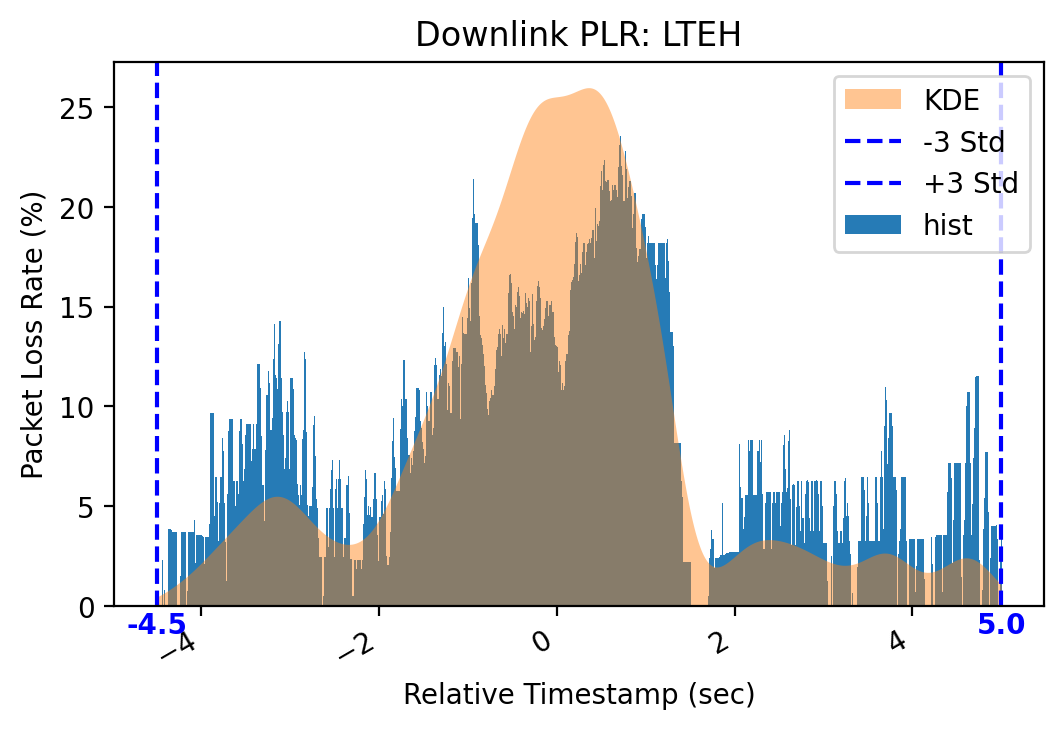

ENBH


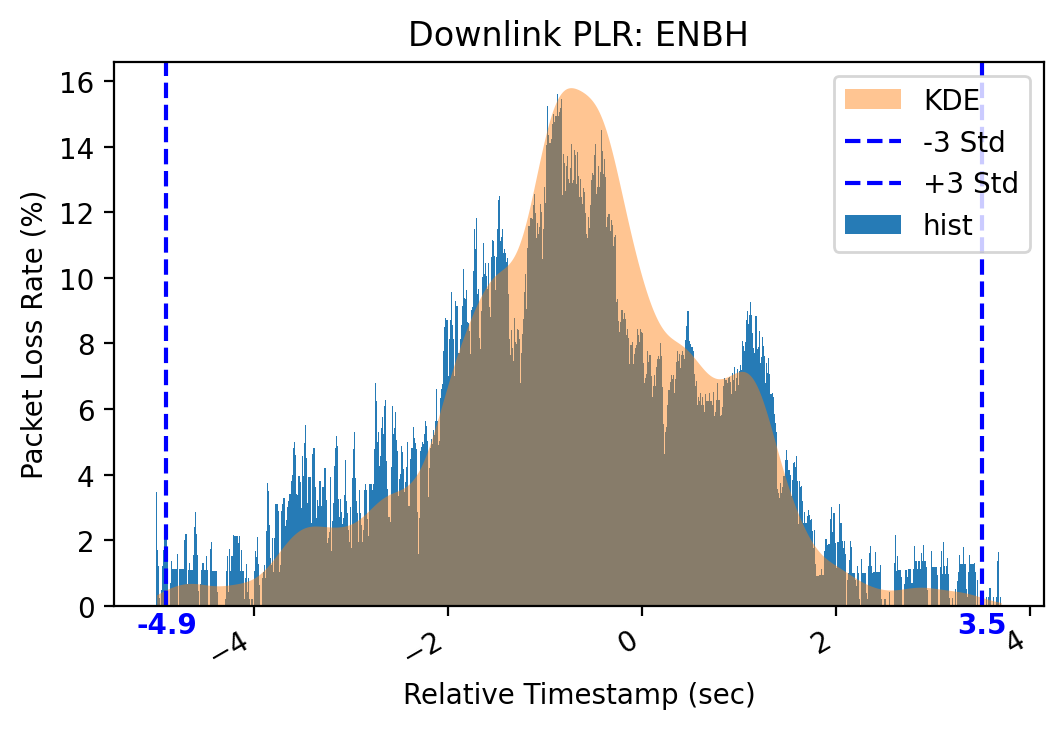

MCGH


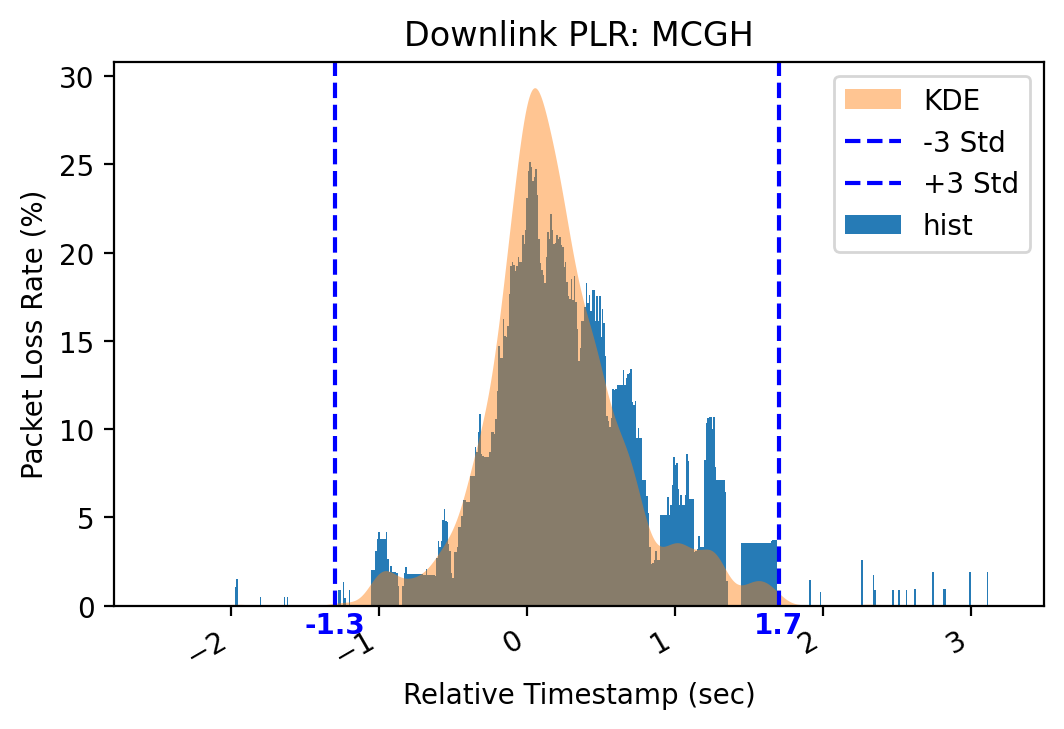

MNBH


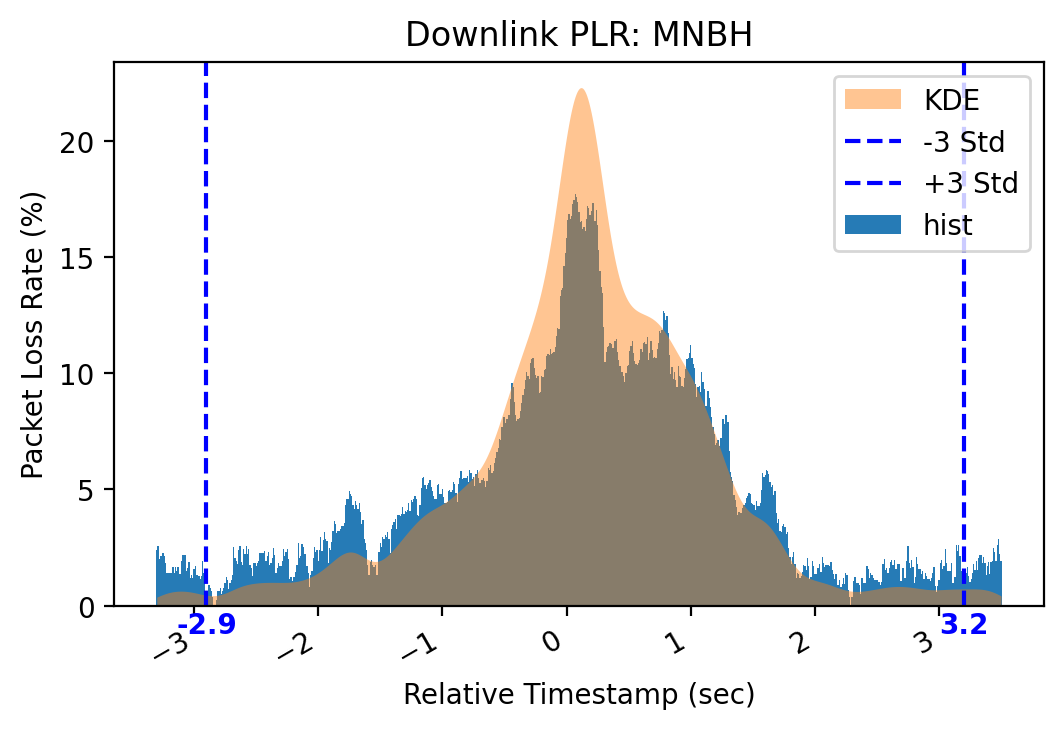

SCGM


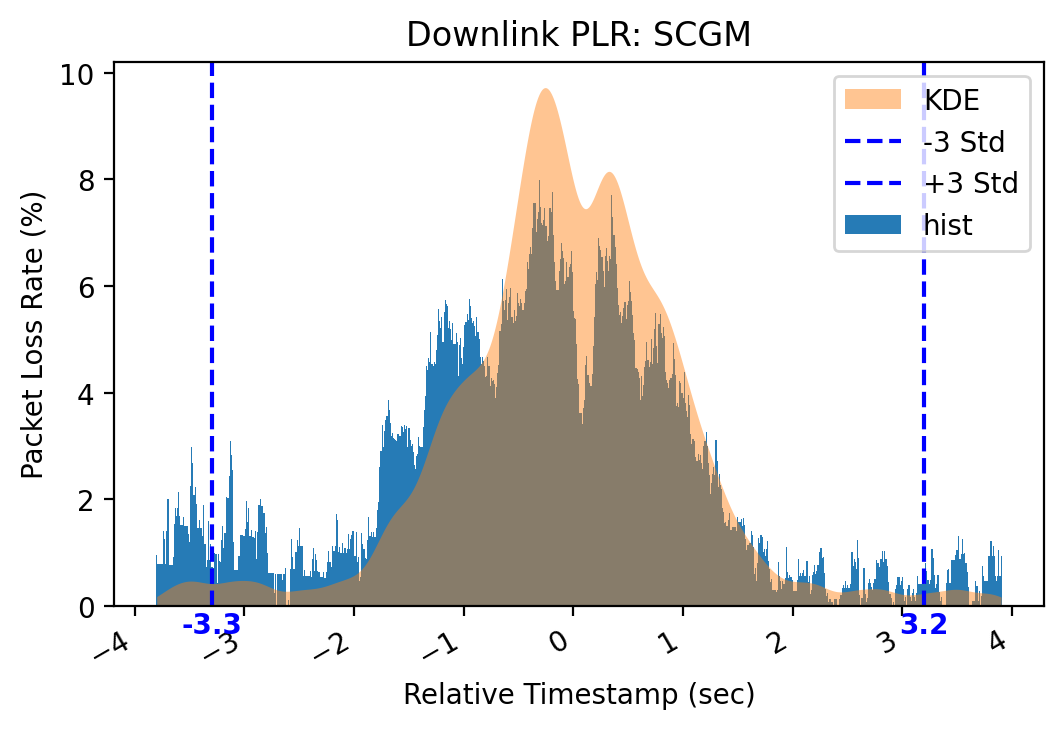

SCGA


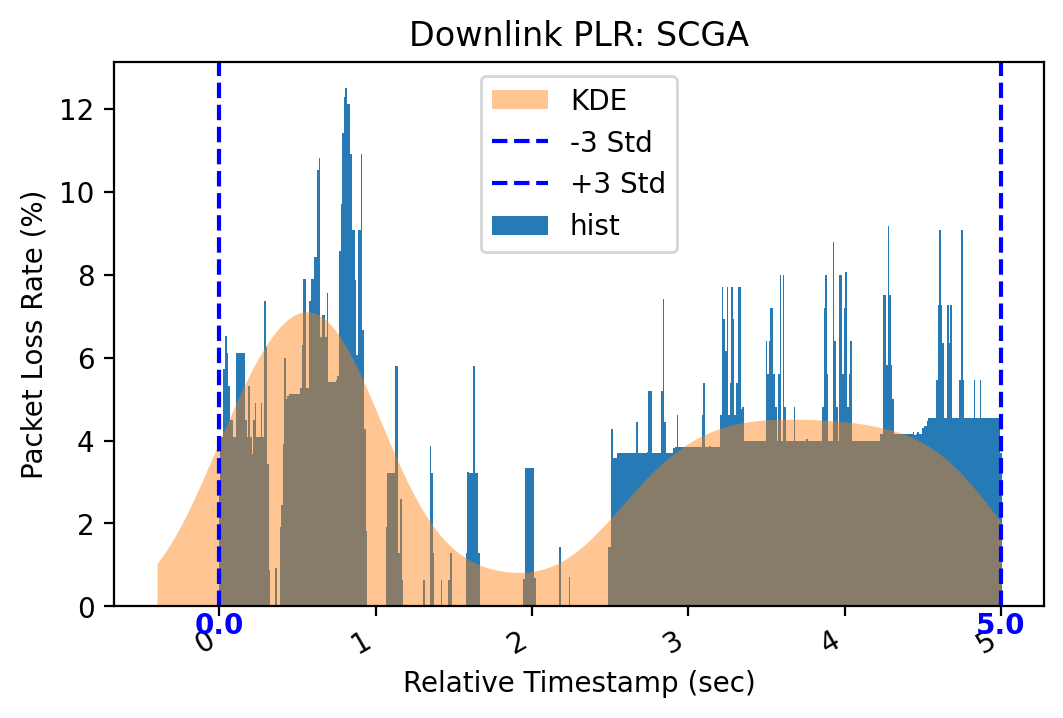

SCGR-I


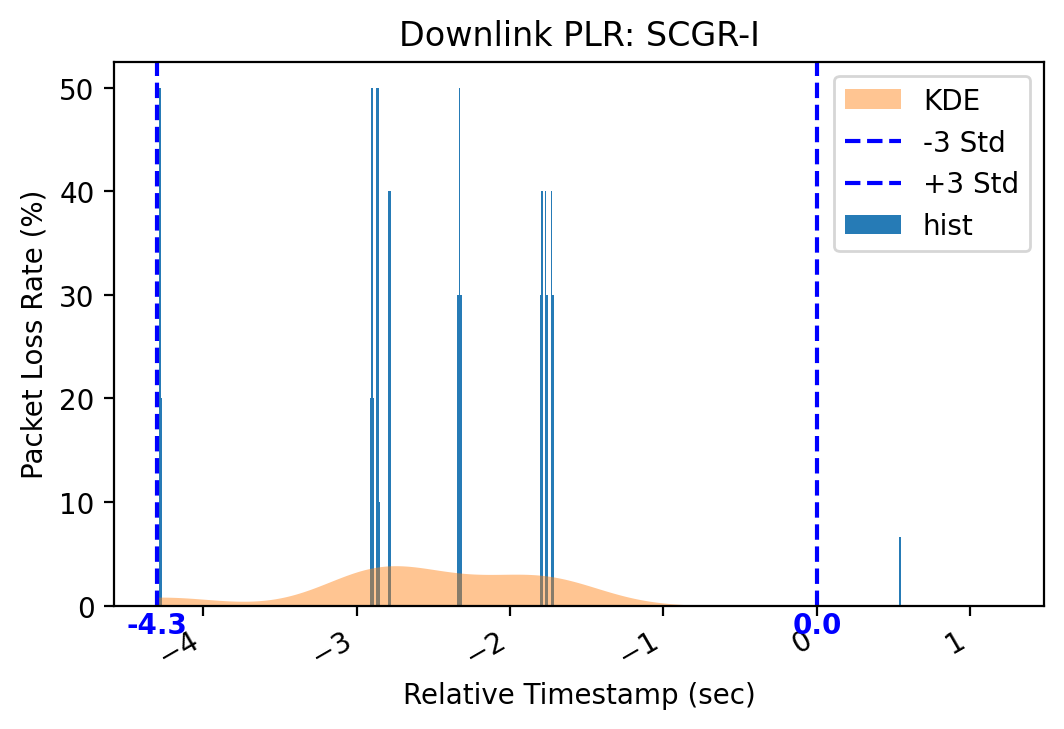

SCGR-II


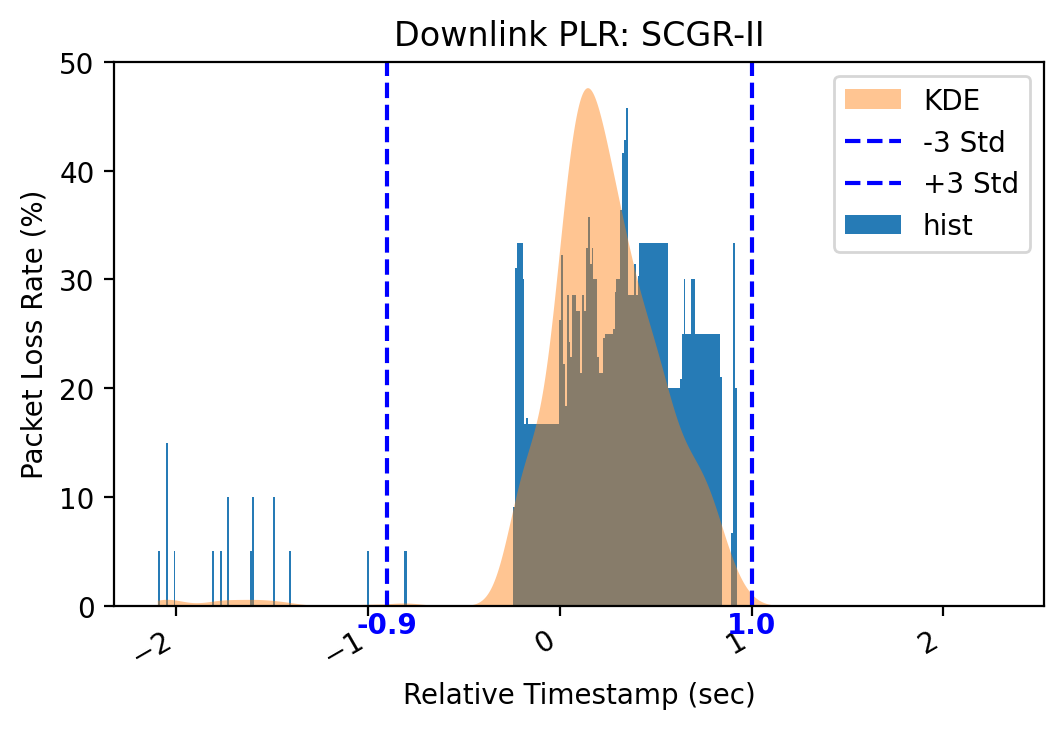

SCGC-I


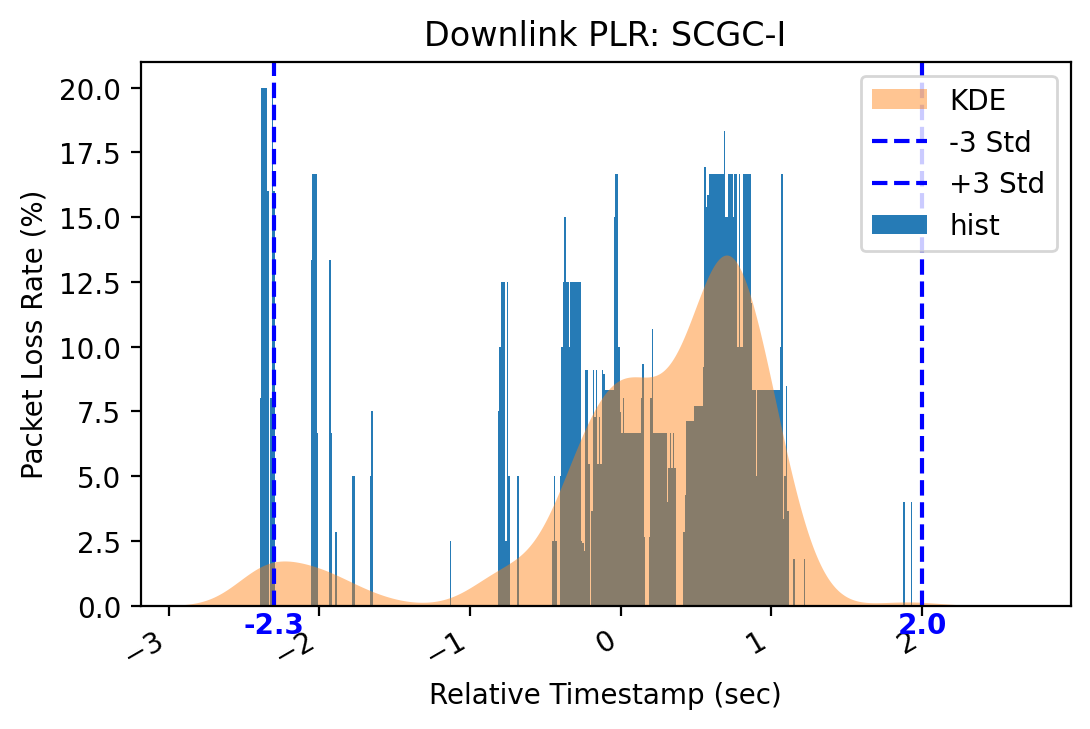

SCGC-II


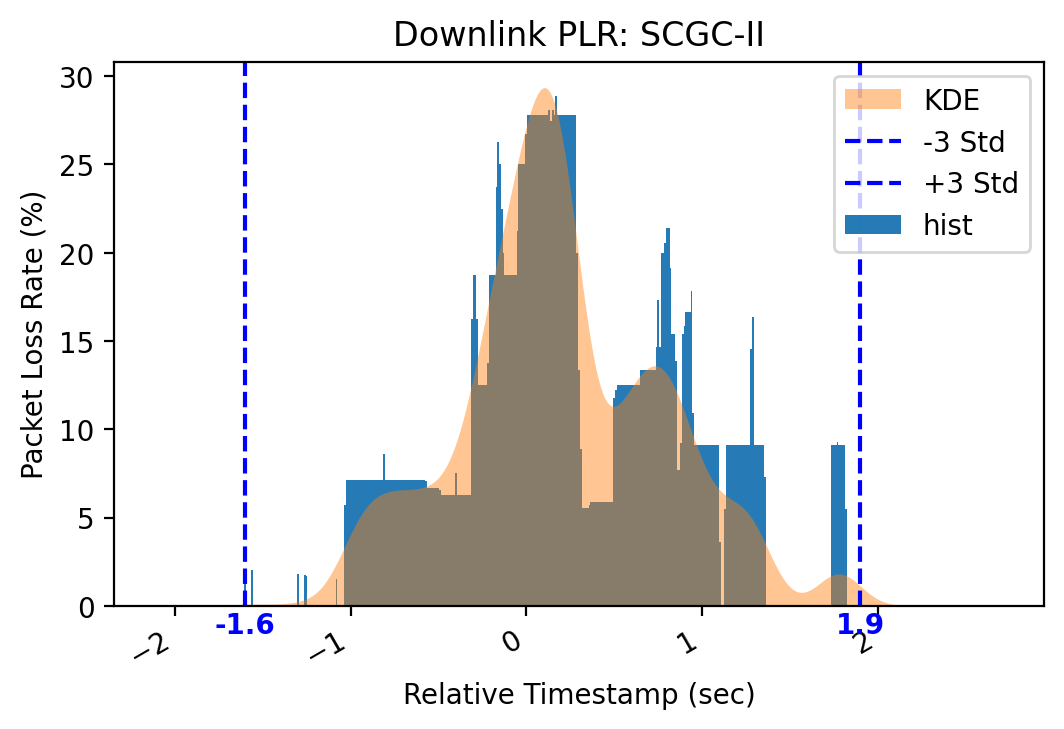

SCGF


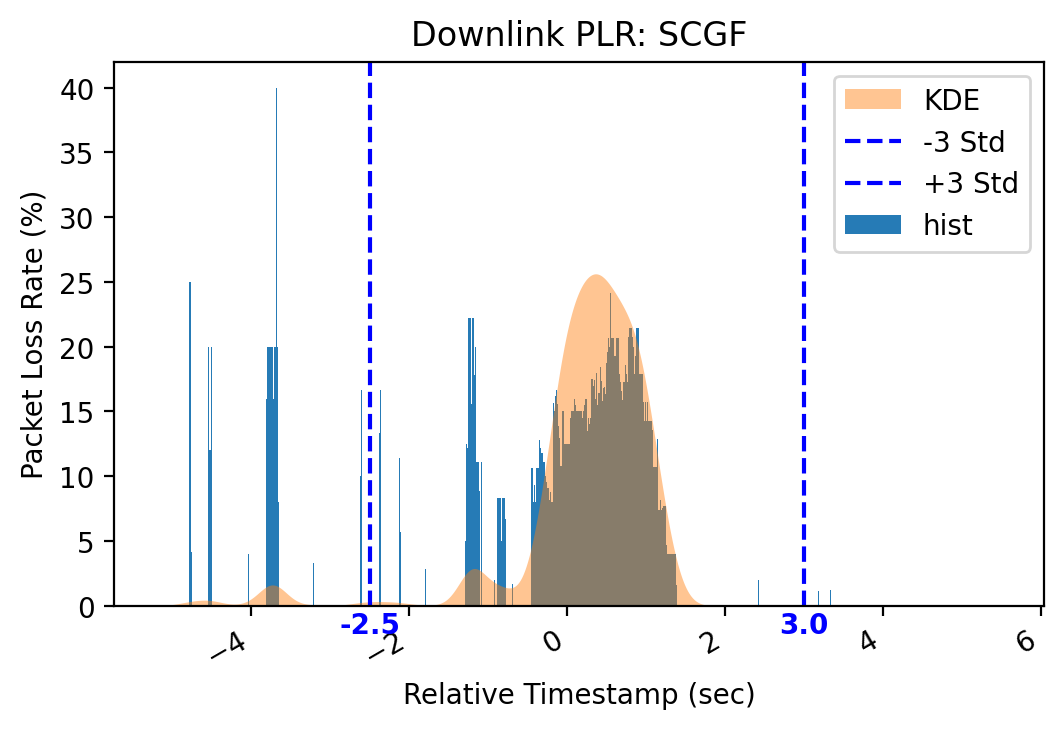

MCGF


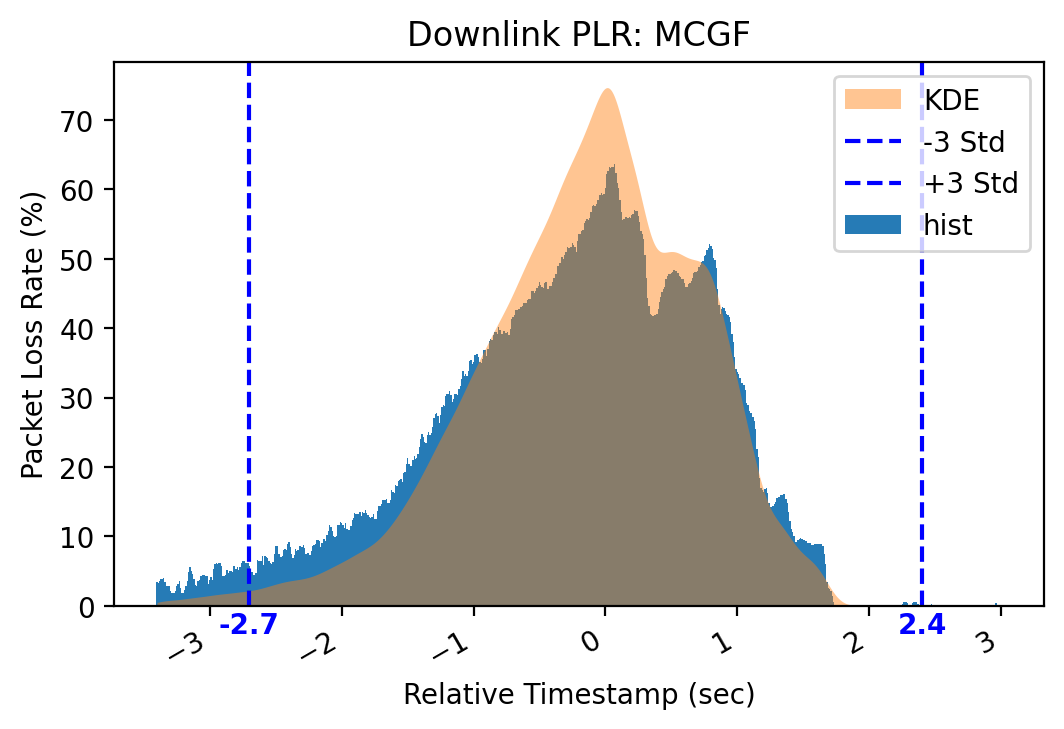

NASR


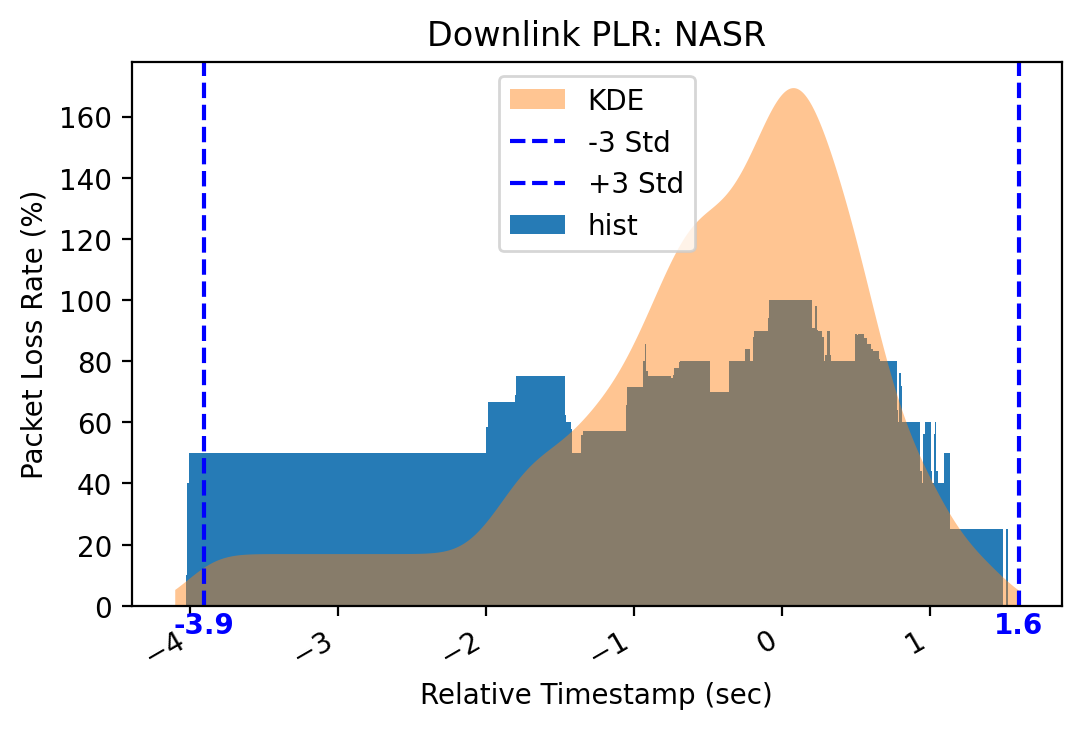

Stable


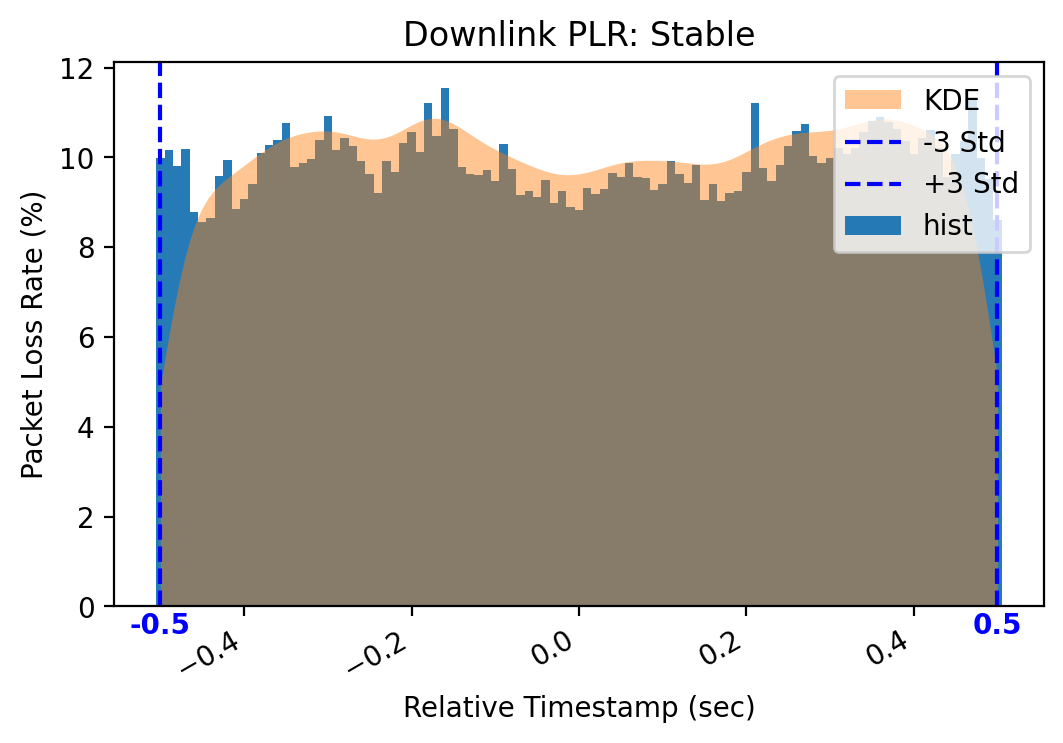

In [7]:
model = Profile(filepaths, 'BR', metrics=['dl_lost'])
model = Profile(filepaths, 'BR', metrics=['dl_lost'], scope_agg=model.scope_models)
model.plot()
model.save_models()

# A Models

In [8]:
# Single Radio Example
dates = data_loader(query_dates=True)

selected_dates = [s for s in dates if s >= '2023-09-12']
# excluded_dates = []
# selected_exps = []
# excluded_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
selected_routes = ['A']
# excluded_routes = []
filepaths = data_loader(mode='sr', selected_dates=selected_dates, selected_routes=selected_routes)

# print(len(filepaths))
# pprint(filepaths)

54
[['/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/handover_info_log.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_dnlk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_uplk_loss_latency.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/diag_log_sm00_2023-10-26_13-30-26_rrc.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/diag_log_sm00_2023-10-26_13-30-26_ml1.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/diag_log_sm00_2023-10-26_13-30-26_nr_ml1.csv'],
 ['/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/handover_info_log.csv',
  '/Users/jackbedford/Desktop/MOXA/Code/data/2023-10-26/U

1/54 /Users/jackbedford/Desktop/MOXA/Code/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/handover_info_log.csv
1/54 /Users/jackbedford/Desktop/MOXA/Code/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_dnlk_loss_latency.csv
1/54 /Users/jackbedford/Desktop/MOXA/Code/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_uplk_loss_latency.csv
2/54 /Users/jackbedford/Desktop/MOXA/Code/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/handover_info_log.csv
2/54 /Users/jackbedford/Desktop/MOXA/Code/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_dnlk_loss_latency.csv
2/54 /Users/jackbedford/Desktop/MOXA/Code/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_uplk_loss_latency.csv
3/54 /Users/jackbedford/Desktop/MOXA/Code/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/handover_info_log.csv
3/54 /Users/jackbedford/Desktop/MOXA/Code/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_dnlk_loss_

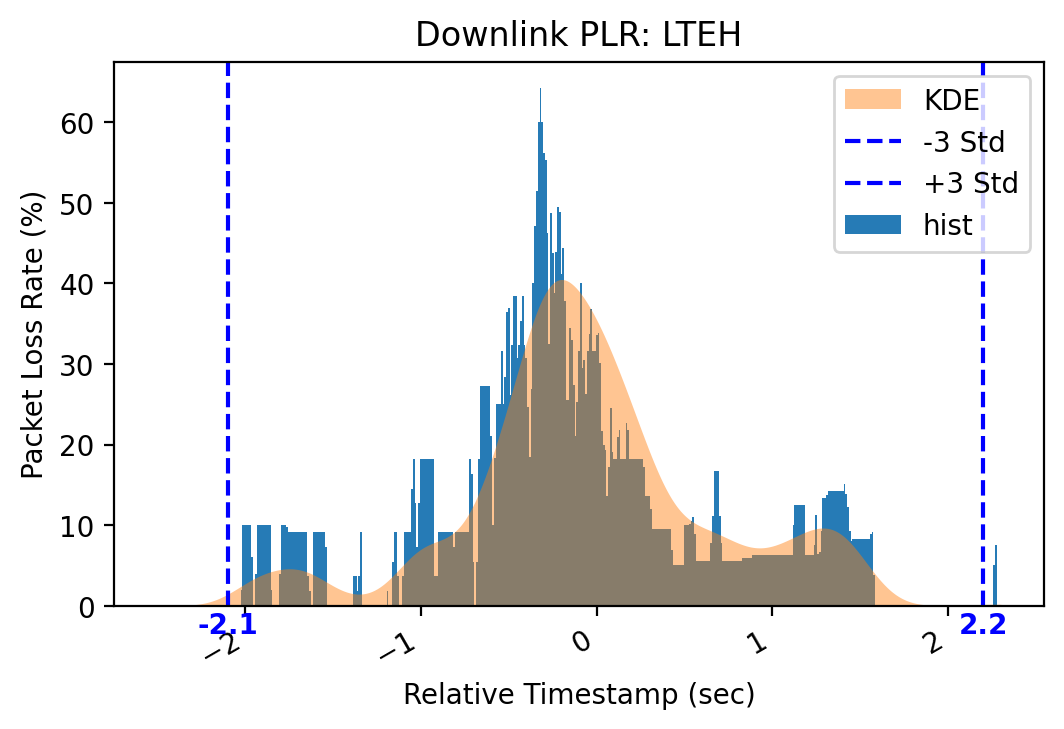

ENBH


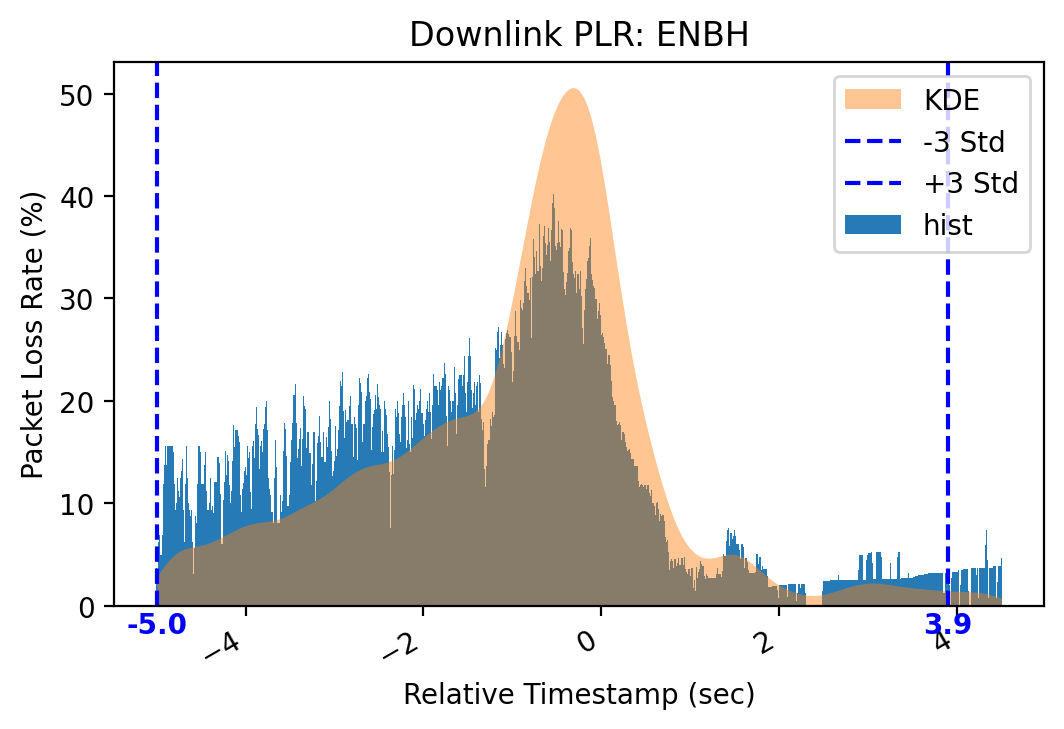

MCGH


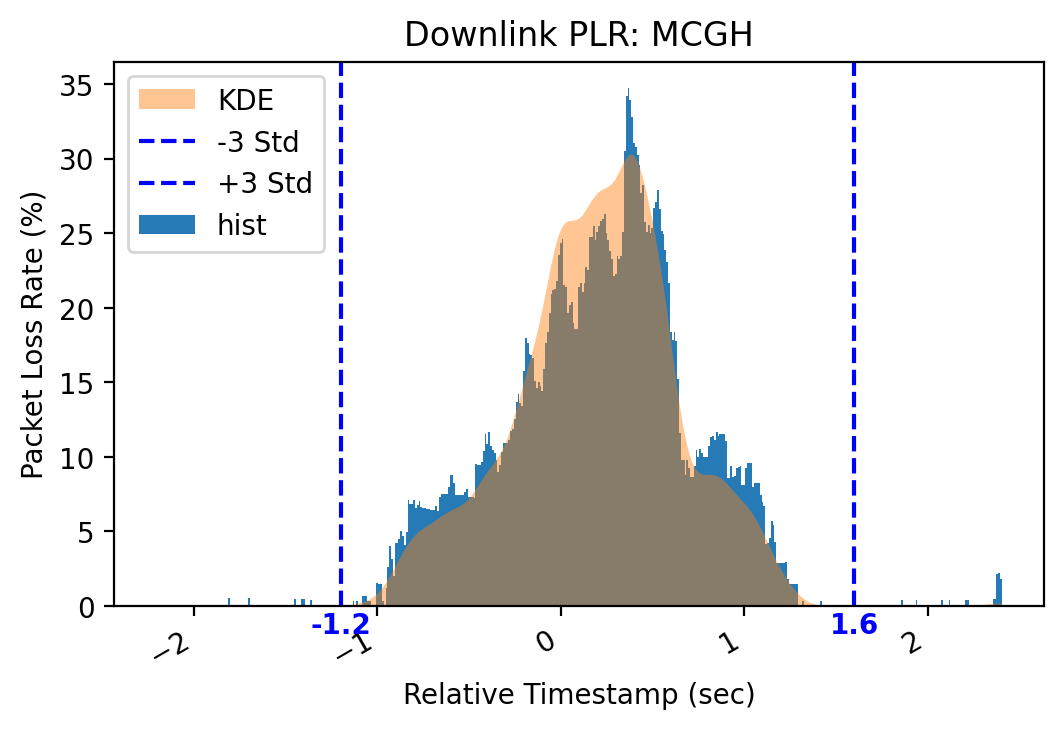

MNBH


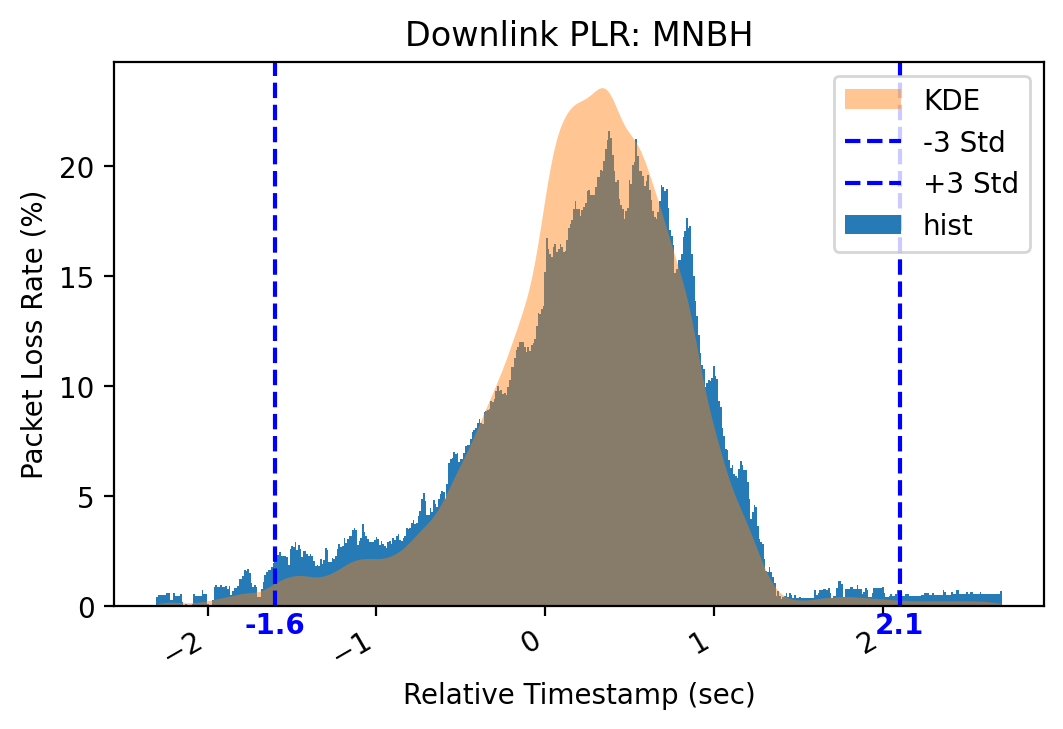

SCGM


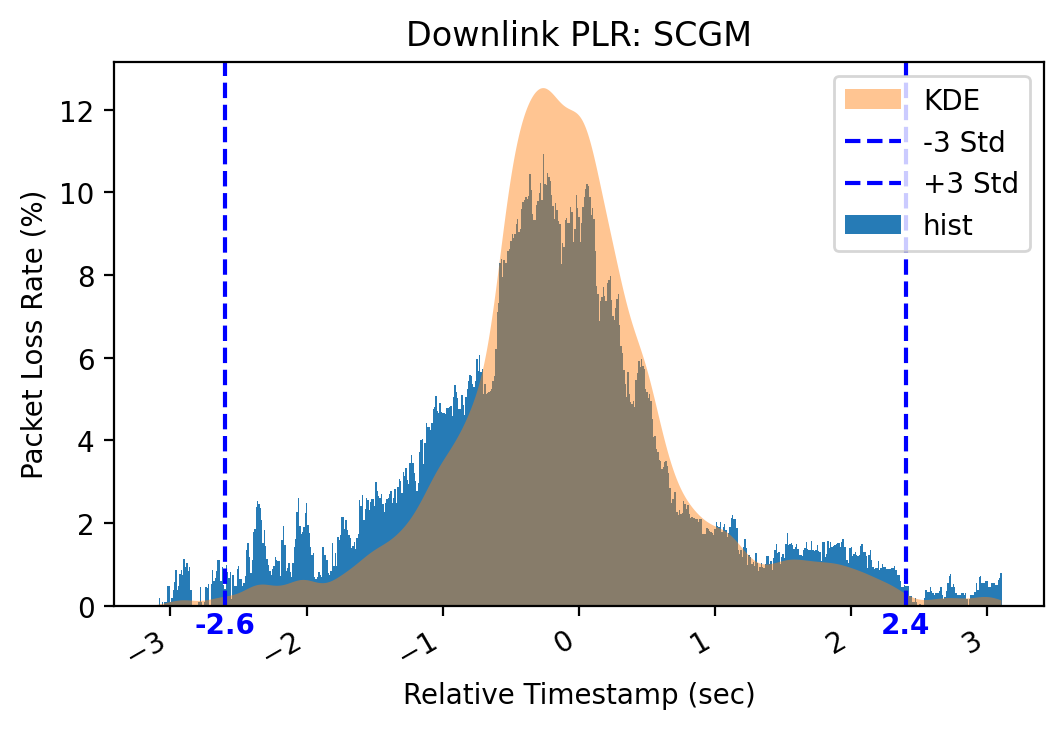

SCGA


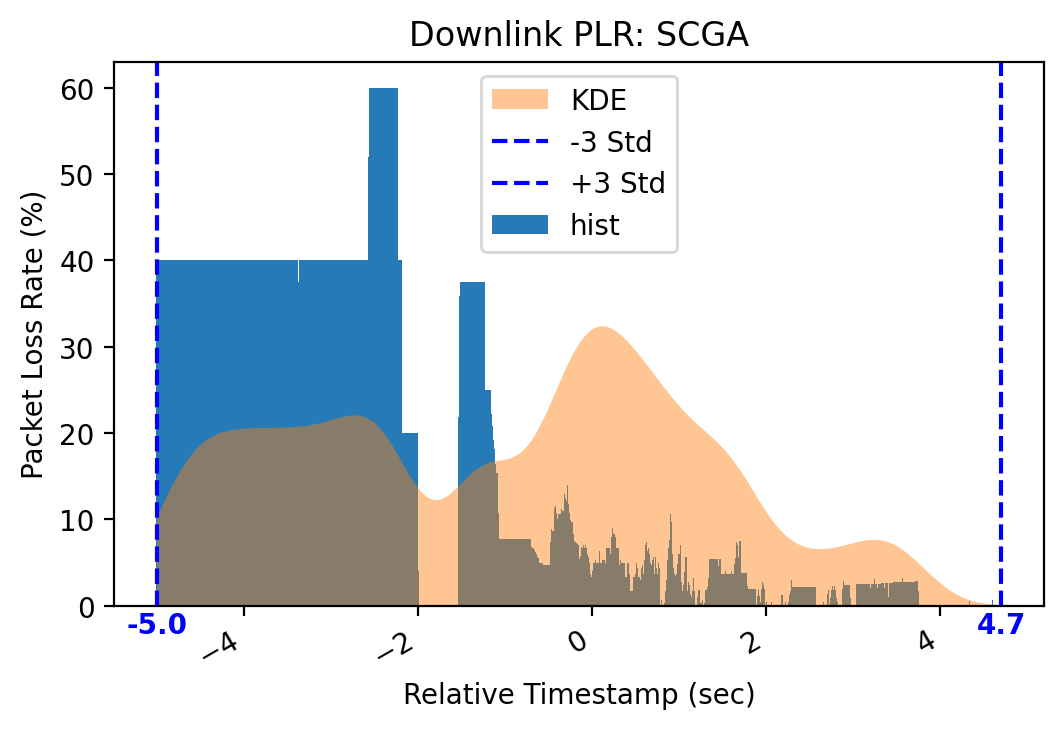

SCGR-I


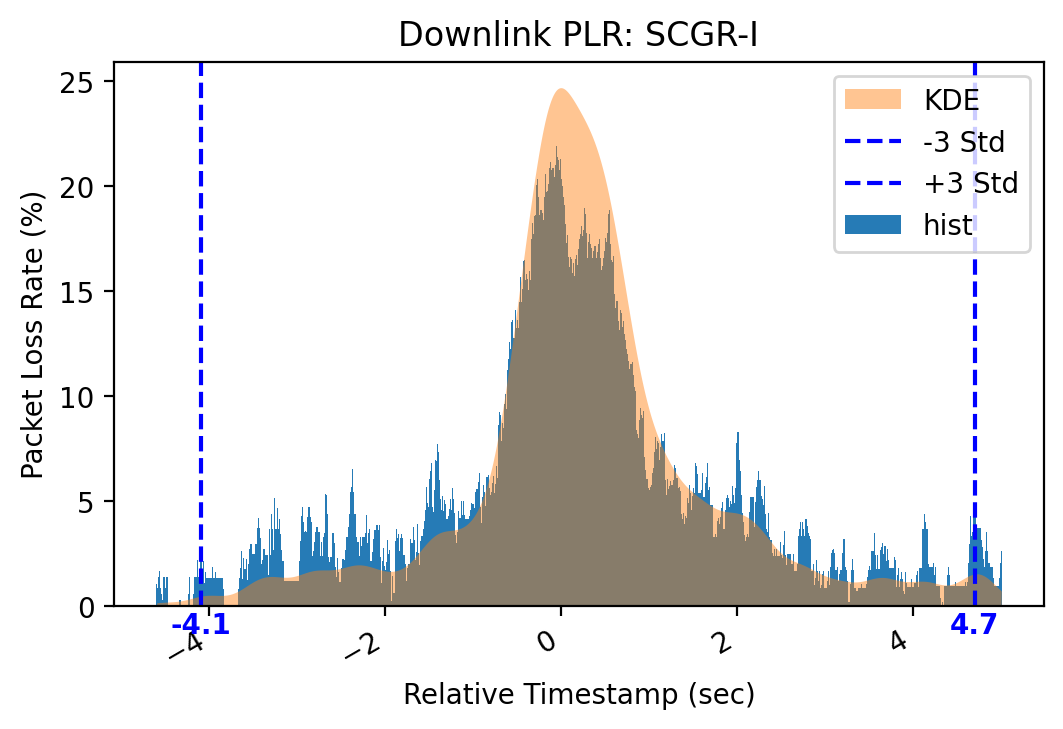

SCGR-II


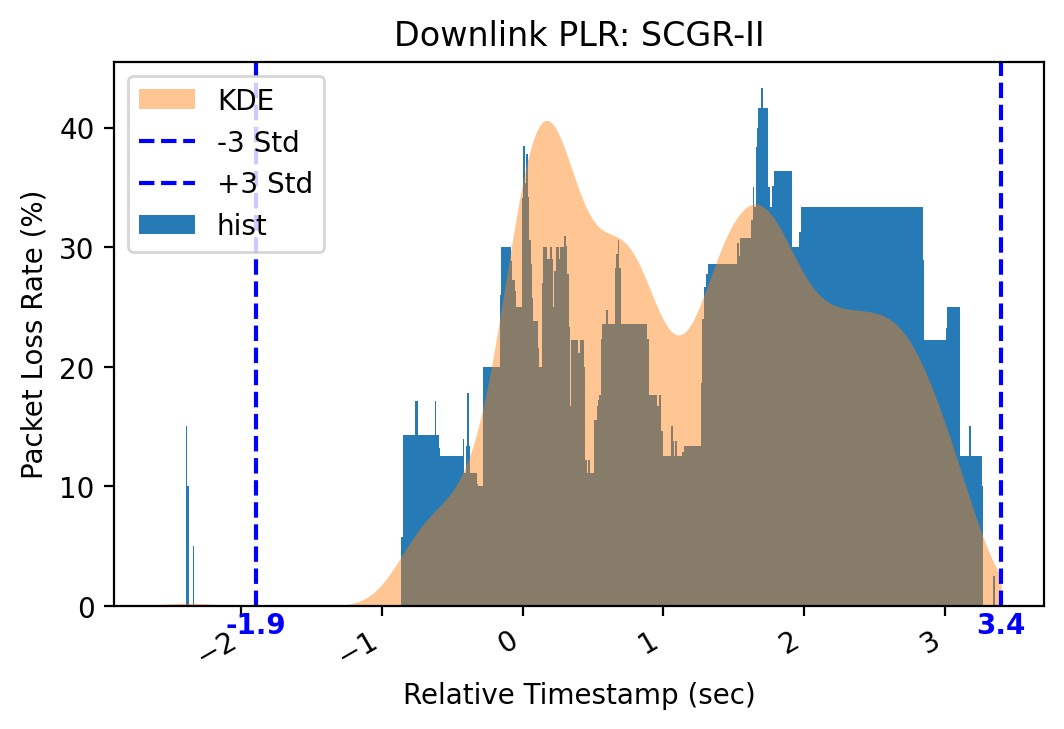

SCGC-I


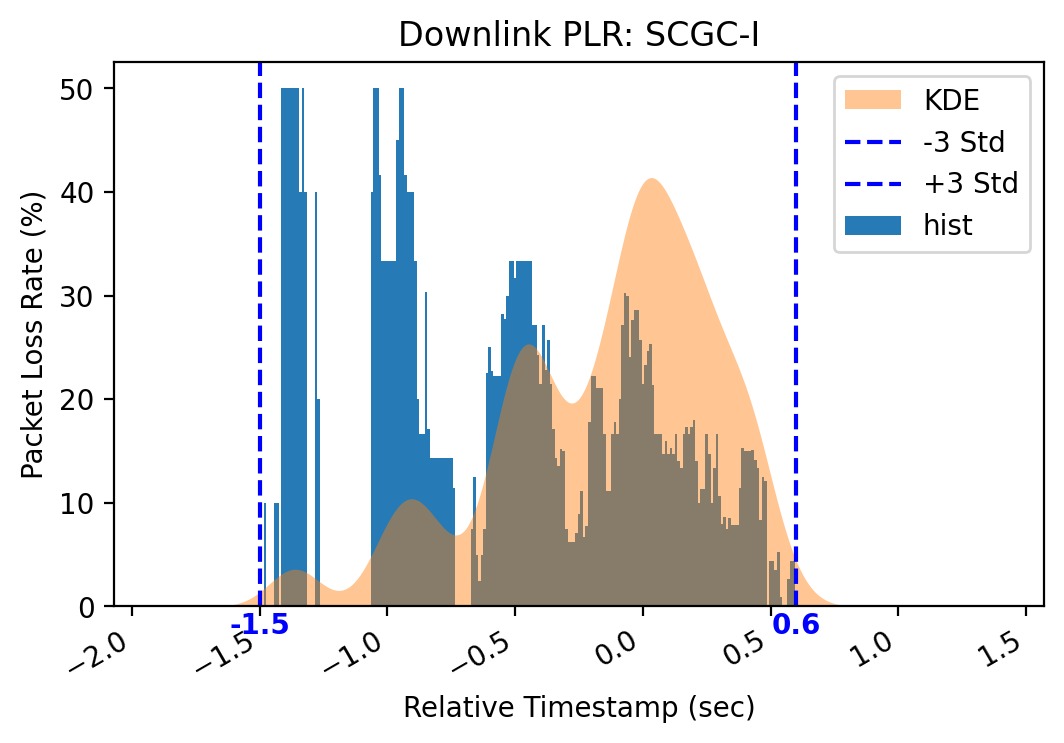

SCGC-II


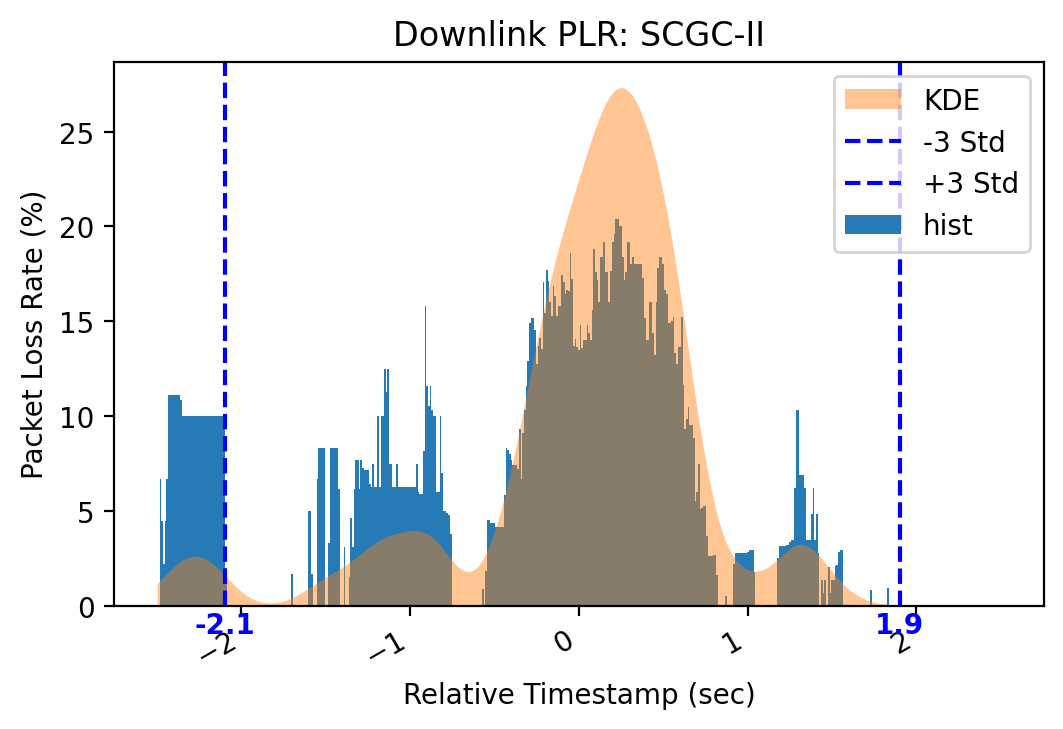

SCGF


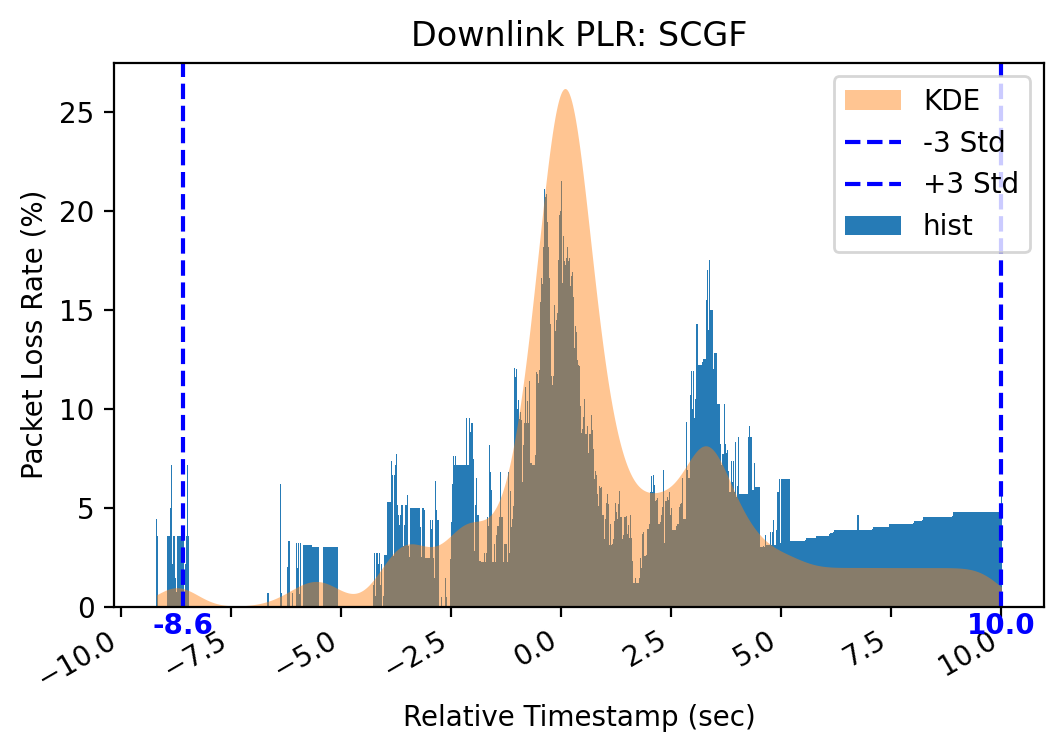

MCGF


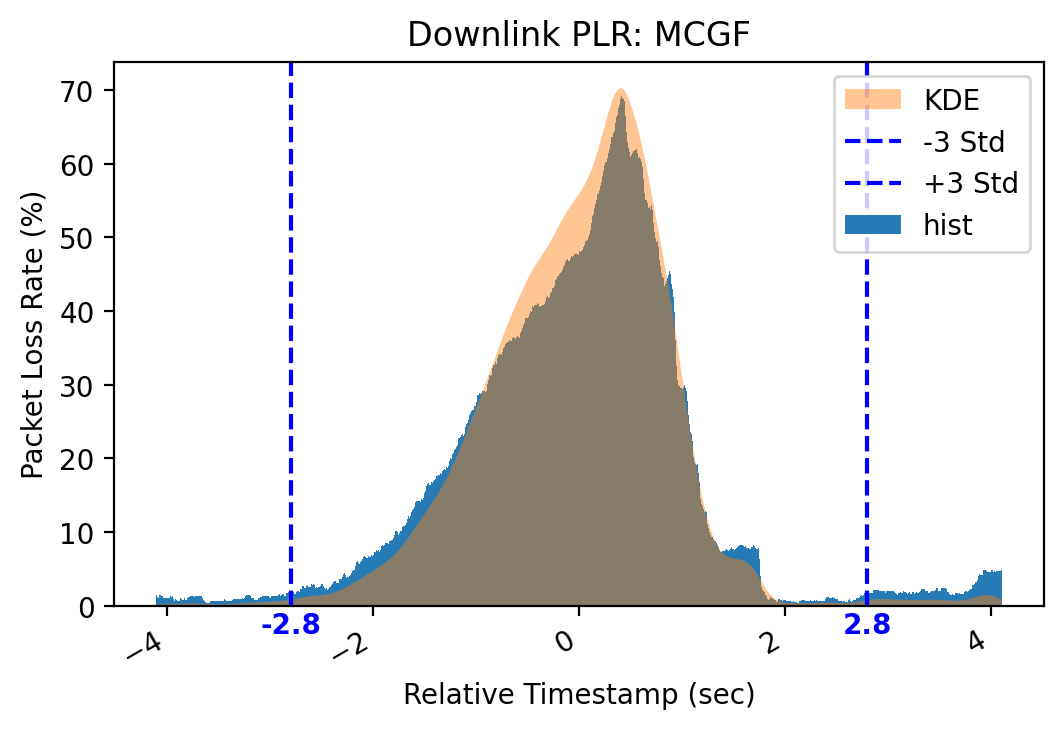

NASR


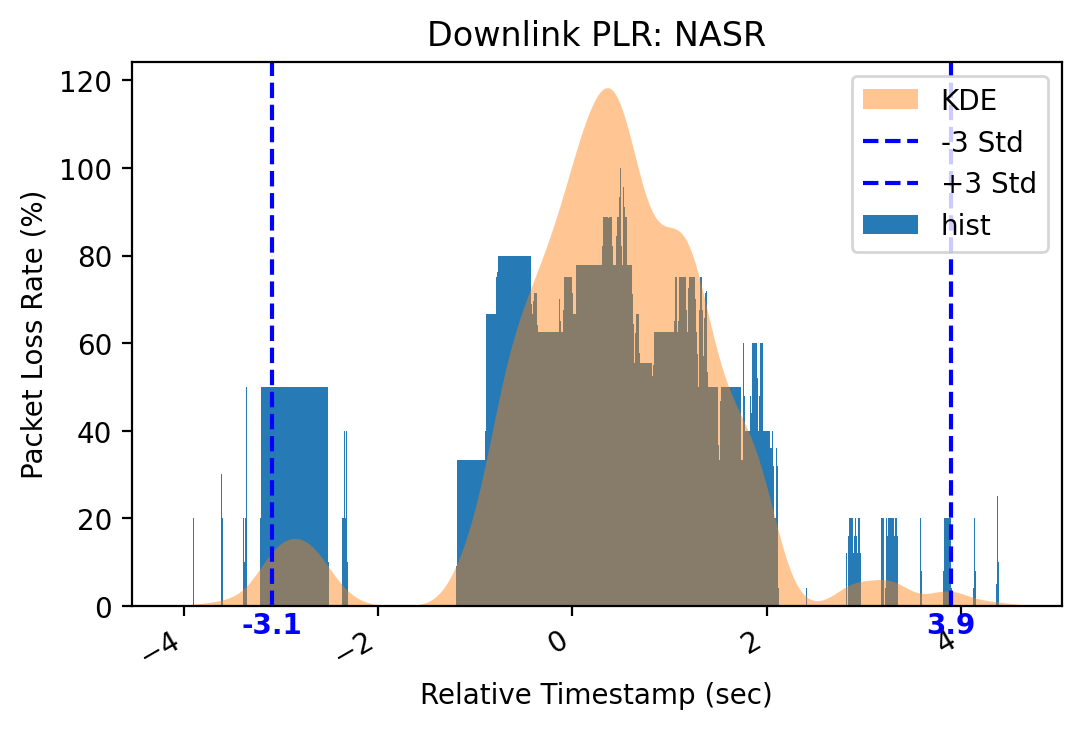

Stable


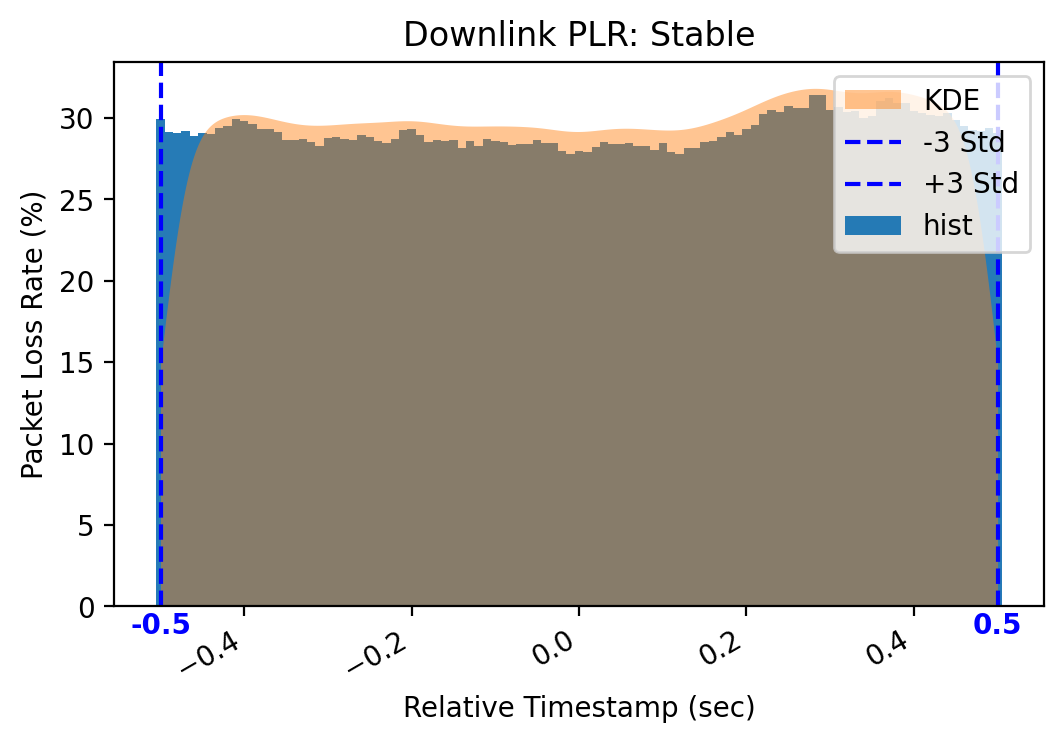

In [9]:
model = Profile(filepaths, 'A', metrics=['dl_lost'])
model = Profile(filepaths, 'A', metrics=['dl_lost'], scope_agg=model.scope_models)
model.plot()
model.save_models()

# Single Radio Evaluation

In [20]:
class Eval:
    def __init__(self, filepaths, model_name='Trial',
                 sp_columns=['type'], ts_column='Timestamp',
                 metrics=['dl_lost', 'dl_excl', 'ul_lost', 'ul_excl']):
        # Initialize instance variables
        self.filepaths = copy.deepcopy(filepaths)
        self.model_name = model_name
        with open(f'{model_name}_kde_models.pkl', 'rb') as f:
            self.kde_models = pickle.load(f)
        with open(f'{model_name}_hist_models.pkl', 'rb') as f:
            self.hist_models = pickle.load(f)
        with open(f'{model_name}_scope_models.pkl', 'rb') as f:
            self.scope_models = pickle.load(f)
        with open(f'{model_name}_sr_prob_models.pkl', 'rb') as f:
            self.sr_prob_models = pickle.load(f)
        self.sp_columns = sp_columns[:]
        self.ts_column = ts_column
        self.metrics = metrics[:]
        
        
        # Sample data
        self.LOSS_GT = []
        self.LOSS_EV = []

        # Standard deviations for error bars
        self.LOSS_STD = []
        
        self.DEVICES = []
        self.TRACES = []

    @staticmethod
    def generate_random_boolean(probability_true):
        return random.random() < probability_true
    
    @staticmethod
    def interpolate(x, y, ratio=0.5):
        """
        Args:
            x, y (datetime.datetime): x < y
            ratio (float): a decimal numeral in a range [0, 1]; 0 means break at x, 1 means break at y.
        Returns:
            (datetime.datetime): breakpoint of interpolation
        """
        return x + (y - x) * ratio
    
    def hist_method(self, df, ho_df, mode_mets, mets, RATE_TYPE):
        scope = self.scope_models[mode_mets]
        hist_model = self.hist_models[mode_mets]
        prob_model = self.sr_prob_models[mode_mets]
        
        this_df = df.copy()
        for i, row in ho_df.iterrows():
            prior_row = ho_df.iloc[i-1] if i != 0 else None
            post_row = ho_df.iloc[i+1] if i != len(ho_df) - 1 else None

            # Peek the next event to avoid HO overlapping with handoverFailure (skip!!)
            if i != len(ho_df) - 1 and pd.notna(row.end) and row.end > post_row.start:
                print('Overlapping event occurs!!')
                # print(i, row['start'], row['end'], row['type'], row['cause'])
                # print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
                continue
            
            # Set prior event if the prior loop is skipped
            if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                prior_row = ho_df.iloc[i-2] if i > 1 else None
            
            # Basic information of the current row
            tag = '_'.join([s for s in row[self.sp_columns] if pd.notna(s)])  # specific column name
            start_ts, end_ts = row['start'], row['end']  # handover start/end time
            interruption_time = (end_ts - start_ts).total_seconds() if pd.notna(end_ts) else 0  # handover interruption time
            
            # Set simple left/right bounds
            current_left_bound = start_ts + pd.Timedelta(seconds=(scope[tag][0]))
            current_right_bound = start_ts + pd.Timedelta(seconds=(scope[tag][1]))
            
            # Set left/right bounds to avoid event overlapping with each other
            if prior_row is not None:
                prior_tag = '_'.join([s for s in prior_row[self.sp_columns] if pd.notna(s)])
                prior_right_bound = prior_row['start'] + pd.Timedelta(seconds=(scope[prior_tag][1]))
                if pd.notna(prior_row['end']):
                    left_bound = min(max(current_left_bound, Eval.interpolate(prior_right_bound, current_left_bound), prior_row['end']), start_ts)
                else:
                    left_bound = min(max(current_left_bound, Eval.interpolate(prior_right_bound, current_left_bound), prior_row['start']), start_ts)
            else:
                left_bound = current_left_bound
            
            if post_row is not None:
                post_tag = '_'.join([s for s in post_row[self.sp_columns] if pd.notna(s)])
                post_left_bound = post_row['start'] + pd.Timedelta(seconds=(scope[post_tag][0]))
                if pd.notna(end_ts):
                    right_bound = max(min(current_right_bound, Eval.interpolate(current_right_bound, post_left_bound), post_row['start']), end_ts)
                else:
                    right_bound = max(min(current_right_bound, Eval.interpolate(current_right_bound, post_left_bound), post_row['start']), start_ts)
            else:
                right_bound = current_right_bound
            
            interval = P.closed(left_bound, right_bound)
            
            # Concatenate PLR from mapping list
            current_df = this_df[this_df['Timestamp'] < interval.upper].copy()
            plr_mapping = hist_model[tag].copy()
            
            current_df[f'relative_time'] = (current_df['Timestamp'] - start_ts).dt.total_seconds()
            current_df[f'window_id'] = ((current_df[f'relative_time'] + 0.005) // 0.01) * 0.01
            
            trigger_probability = prob_model[tag]
            
            if plr_mapping.empty:
                tmp = current_df.copy().rename(columns={mets: f'{mets}_x'})
            else:
                tmp = pd.merge(current_df, plr_mapping, on='window_id', how='left')
                tmp[RATE_TYPE] = tmp[RATE_TYPE].fillna(0)
                
                if not Eval.generate_random_boolean(trigger_probability):
                    tmp[RATE_TYPE] = 0
            
            if i == 0:
                answer = tmp.copy()
            else:
                answer = pd.concat([answer, tmp], axis=0)
            
            # Update dataframe to accelerate the speed
            this_df = this_df[this_df[self.ts_column] >= interval.upper].copy()
        
        answer = pd.concat([answer, this_df], axis=0)
        # display(answer)
        
        # Consider stable duration
        stable_df = answer[answer['tx_count'].isnull()].copy()[['seq', 'lost_x', 'excl', 'Timestamp']].rename(columns={'lost_x': 'lost'})

        stable_df['Timestamp_sec'] = stable_df['Timestamp'].dt.floor('S')
        stable_df['relative_time'] = (stable_df['Timestamp'] - stable_df['Timestamp_sec']).dt.total_seconds() - 0.5
        stable_df['window_id'] = ((stable_df['relative_time'] + 0.01 / 2) // 0.01) * 0.01

        plr_mapping = hist_model['Stable'].copy()
        stable_df = pd.merge(stable_df, plr_mapping, on='window_id', how='left').rename(columns={'PLR': 'PLR_trig'})

        trig_p_mapping = stable_df[~stable_df['Timestamp_sec'].duplicated()].reset_index(drop=True)
        triggered_p = prob_model['Stable']
        random_bool_array = [Eval.generate_random_boolean(triggered_p) for _ in range(len(trig_p_mapping))]
        trig_p_mapping['trigger'] = random_bool_array
        trig_p_mapping = trig_p_mapping[['Timestamp_sec', 'trigger']]

        stable_df = pd.merge(stable_df, trig_p_mapping, on='Timestamp_sec', how='left')
        stable_df['PLR'] = stable_df['PLR_trig'] * stable_df['trigger']

        del stable_df['Timestamp_sec'], stable_df['PLR_trig'], stable_df['trigger']
        
        answer = answer[answer['tx_count'].notnull()].copy()
        # display(answer)
        
        answer = pd.concat([answer, stable_df], axis=0)
        answer = answer.sort_values(by='Timestamp').reset_index(drop=True)
        answer['PLR'] = answer['PLR'] / 100
        answer['Y'] = answer['PLR'].apply(Eval.generate_random_boolean)
        
        eval_value = answer['Y'].mean() * 100
        ground_value = df['lost'].mean() * 100
        
        return answer, eval_value, ground_value
    
    
    def hist_method_all(self, N=3):
        for mode_mets in ['dl_lost']:
            for i, filepath in enumerate(filepaths):
                
                # if i > 1:
                #     break
                
                ho_df = pd.read_csv(filepath[0], parse_dates=['start', 'end'])
                
                if ho_df.empty:
                    print('******** Empty RRC Data ********')
                    continue
                
                df = pd.read_csv(filepath[1], parse_dates=['Timestamp'])[['seq', 'Timestamp', 'lost', 'excl', 'latency']]
                df, ho_df, empty_data = data_aligner(df, ho_df)
                
                if empty_data:
                    print('******** Empty Data:', mode_mets, '********')
                    continue
                
                loss_rate_list = []
                for iter_round in tqdm(range(N), ncols=1000):
                    _, eval_value, ground_value = eval.hist_method(df, ho_df, mode_mets='dl_lost', mets='lost', RATE_TYPE='PLR')
                    loss_rate_list.append(eval_value)
        
                mean_value = np.mean(loss_rate_list)
                std_deviation = np.std(loss_rate_list)

                print()
                print("Mean:", mean_value)
                print("Standard Deviation:", std_deviation)
                print("Ground Truth:", ground_value)
                
                self.LOSS_GT.append(ground_value)
                self.LOSS_EV.append(mean_value)
                self.LOSS_STD.append(std_deviation)
                
                
                path = filepath[0]

                # 找到 "sm" 的位置
                sm_index = path.index("sm")
                # 从 "sm" 的位置开始找到下一个斜杠 "/"
                next_slash_index = path.index("/", sm_index)
                # 截取 "sm00" 标签
                sm_label = path[sm_index:next_slash_index]
                # print("截取的标签为:", sm_label)
                
                self.DEVICES.append(sm_label)
                
                # 找到 "sm" 的位置
                sm_index = path.index("#")
                # 从 "sm" 的位置开始找到下一个斜杠 "/"
                next_slash_index = path.index("/", sm_index)
                # 截取 "sm00" 标签
                sm_label = path[sm_index:next_slash_index]
                # print("截取的标签为:", sm_label)
                
                self.TRACES.append(sm_label)
    
    
    def plot(self):
        # Sample data
        x = self.LOSS_GT.copy()
        y = self.LOSS_EV.copy()

        # Standard deviations for error bars
        y_error = self.LOSS_STD.copy()

        # Create figure and axes
        fig, ax = plt.subplots(figsize=(6, 4))

        # Scatter plot with error bars and horizontal caps
        ax.errorbar(x, y, yerr=y_error, linestyle='None', marker='o', color='tab:blue', capsize=5)
        ax.scatter([], [], linestyle='None', marker='o', color='tab:blue', label='Data Points')

        # Regression line
        coefficients = np.polyfit(x, y, 1)
        regression_line = np.poly1d(coefficients)
        ax.plot(ax.get_xlim(), regression_line(ax.get_xlim()), linestyle='--', linewidth=1.1, color='tab:blue', label='Regression Line')

        # Annotate the slope of the regression line
        slope_annotation = f'Slope: {coefficients[0]:.2f}'
        ax.annotate(slope_annotation, xy=(0.5, 0.85), xycoords='axes fraction', fontsize=10, fontstyle='italic', fontweight='bold', color='tab:blue')

        # Annotate MSE From the regression line
        y_pred = regression_line(x)
        mse = mean_squared_error(y, y_pred)
        slope_annotation = f'MSE: {mse:.3f}'
        ax.annotate(slope_annotation, xy=(0.5, 0.8), xycoords='axes fraction', fontsize=10, fontstyle='italic', fontweight='bold', color='tab:blue')

        # 45-Degree Line
        ax.plot(ax.get_xlim(), ax.get_xlim(), linestyle='-', linewidth=1.1, color='tab:pink', label='45-Degree Line', alpha=0.9)

        # Set labels and title
        ax.set_xlabel('PLR Ground Truth')
        ax.set_ylabel('PLR Evaluated')
        # ax.set_title('A Profile Evaluate 9 Traces From A5 Data: Single')

        for i, sm_label in enumerate(self.DEVICES):
            ax.annotate(sm_label, xy=(x[i], y[i]))
            
        # Add a legend
        ax.legend()

        # Show the plot
        plt.show()

# BR Eval

In [21]:
# Single Radio Example
dates = data_loader(query_dates=True)

selected_dates = [s for s in dates if s >= '2023-09-12']
# excluded_dates = []
# selected_exps = []
# excluded_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
selected_routes = ['BR']
# excluded_routes = []
filepaths = data_loader(mode='sr', selected_dates=selected_dates, selected_routes=selected_routes)

# print(len(filepaths))
# pprint(filepaths)

  0%|                                                                                                         …


Mean: 0.522096201433848
Standard Deviation: 0.045549462042384935
Ground Truth: 0.47852155675062485


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.9629925927807185
Standard Deviation: 0.08125936074775245
Ground Truth: 0.8694940567523886


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.0478138250378075
Standard Deviation: 0.05209858540982117
Ground Truth: 0.9567609247607215


  0%|                                                                                                         …


Mean: 0.6765239896878829
Standard Deviation: 0.050665301217203106
Ground Truth: 0.4984864101429921


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.5491392890677965
St

  0%|                                                                                                         …


Mean: 0.7430499852673962
Standard Deviation: 0.050456523017542845
Ground Truth: 0.8281534062650133


  0%|                                                                                                         …


Mean: 0.7613217062165943
Standard Deviation: 0.04124070151833213
Ground Truth: 0.8278006703393532


  0%|                                                                                                         …


Mean: 0.6098804154664826
Standard Deviation: 0.024008234293569058
Ground Truth: 0.2553808101779835


  0%|                                                                                                         …


Mean: 0.31452286704701005
Standard Deviation: 0.04922199784411232
Ground Truth: 0.2531938474388903


  0%|                                                                                                         …


Mean: 0.627849193812006
Standard Deviation: 0.04549429800835729
Ground Truth: 0.39240287062782386


  0%|                                                                                                         …


Mean: 0.6762187249702548
Standard Deviation: 0.04898882956843799
Ground Truth: 0.7608237217961293


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.6023214948781622
Standard Deviation: 0.02432946481481842
Ground Truth: 0.4394386338821198


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.5819656232333433
Standard Deviation: 0.06166608163773396
Ground Truth: 0.4194073214050283


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
O

  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.8835794225437775
Standard Deviation: 0.11463336122813002
Ground Truth: 0.8308098722765254


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.0350393572168395
Standard Deviation: 0.01524631467506433
Ground Truth: 1.0958915455259493


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.6457021671721207
Standard Deviation: 0.04362322007994153
Ground Truth: 0.6081324515378277


  0%|                                                                                                         …


Mean: 0.21249476585543178
Standard Deviation: 0.0474235524964667
Ground Truth: 0.01967118068497122


  0%|                                                                                                         …


Mean: 0.3685207380257456
Standard Deviation: 0.016411656051909963
Ground Truth: 0.24924769538157043


  0%|                                                                                                         …


Mean: 0.39100622991342754
Standard Deviation: 0.04549736750533666
Ground Truth: 0.15029236670780324


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.4126208971799983
Standard Deviation: 0.05341535671515558
Ground Truth: 0.34822287935748697


  0%|                                                                                                         …


Mean: 0.2674424866348391
Standard Deviation: 0.05309150371357486
Ground Truth: 0.0415020973878747


  0%|                                                                                                         …


Mean: 0.27710173588987425
Standard Deviation: 0.08147499473971101
Ground Truth: 1.1665987723311433


  0%|                                                                                                         …


Mean: 0.4113919569773567
Standard Deviation: 0.03683842806069791
Ground Truth: 0.16183629882334424


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.3809453516450767
Standard Deviation: 0.05992682108151518
Ground Truth: 0.307276884812598


  0%|                                                                                                         …


Mean: 0.27748527259625744
Standard Deviation: 0.018735713095626282
Ground Truth: 0.05933676539412984


  0%|                                                                                                         …


Mean: 0.25649597113985056
Standard Deviation: 0.03423179642719784
Ground Truth: 0.26276386074142166


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.4400894005091496
Standard Deviation: 0.014667448801100262
Ground Truth: 0.4791451076312571


  0%|                                                                                                         …


Mean: 0.26078892748029775
Standard Deviation: 0.05064504611432823
Ground Truth: 0.2967278697589834


  0%|                                                                                                         …


Mean: 0.4388249514798555
Standard Deviation: 0.009923998654643561
Ground Truth: 0.6152337695930293


  0%|                                                                                                         …


Mean: 0.21659104508386073
Standard Deviation: 0.01803366748807223
Ground Truth: 0.09827123859529853


  0%|                                                                                                         …


Mean: 0.3421216530725389
Standard Deviation: 0.021217048043258337
Ground Truth: 0.19439863977960553


  0%|                                                                                                         …


Mean: 0.4926505067608497
Standard Deviation: 0.01461400149172963
Ground Truth: 0.8413470103889181


  0%|                                                                                                         …


Mean: 0.4387658878049591
Standard Deviation: 0.09680819993237827
Ground Truth: 0.4714500509502398


  0%|                                                                                                         …


Mean: 0.2631734600290609
Standard Deviation: 0.04267984374763419
Ground Truth: 0.11537444673356341


  0%|                                                                                                         …


Mean: 0.35831131894624546
Standard Deviation: 0.02860848015476729
Ground Truth: 0.3002318191568282


  0%|                                                                                                         …


Mean: 1.0611611412896356
Standard Deviation: 0.01859935539007416
Ground Truth: 1.2318131778888668


  0%|                                                                                                         …


Mean: 0.8915969245620697
Standard Deviation: 0.14113624921354825
Ground Truth: 1.1610129484271754


  0%|                                                                                                         …


Mean: 0.8233336990562424
Standard Deviation: 0.030742555174330492
Ground Truth: 1.2194452945898033


  0%|                                                                                                         …


Mean: 0.6433434513690628
Standard Deviation: 0.08802187672373671
Ground Truth: 0.5541699902188311


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
O

  0%|                                                                                                         …


Mean: 0.8595446564709143
Standard Deviation: 0.12567544836342737
Ground Truth: 1.0946091114910133


  0%|                                                                                                         …


Mean: 0.9172053605910655
Standard Deviation: 0.096677060381222
Ground Truth: 1.1247423833912633


  0%|                                                                                                         …


Mean: 0.8475597915498123
Standard Deviation: 0.033896775970292926
Ground Truth: 1.0303399118295264


  0%|                                                                                                         …


Mean: 0.4243104504042799
Standard Deviation: 0.026282105532616996
Ground Truth: 0.5913157714281589


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.9758015454533822
Standard Deviation: 0.057523299632865
Ground Truth: 0.9286678926999836


  0%|                                                                                                         …


Mean: 1.076005088845396
Standard Deviation: 0.05496739237861961
Ground Truth: 1.6851681748001641


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.0759503390353442
Standard Deviation: 0.0607642384634408
Ground Truth: 1.0938898250306786


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.920104232102557
Standard Deviation: 0.031808946045487424
Ground Truth: 0.8869267816011726


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
O

  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.9527785418187961
Standard Deviation: 0.0728074891154888
Ground Truth: 0.9308579335149346


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 0.9950227917463371
Standard Deviation: 0.04341559146160366
Ground Truth: 0.859428829924403


  0%|                                                                                                         …


Mean: 0.7676207015613934
Standard Deviation: 0.032576498362838435
Ground Truth: 0.856663027727599


  0%|                                                                                                         …


Mean: 0.40470040721349615
Standard Deviation: 0.01957193801910981
Ground Truth: 0.24167539267015709


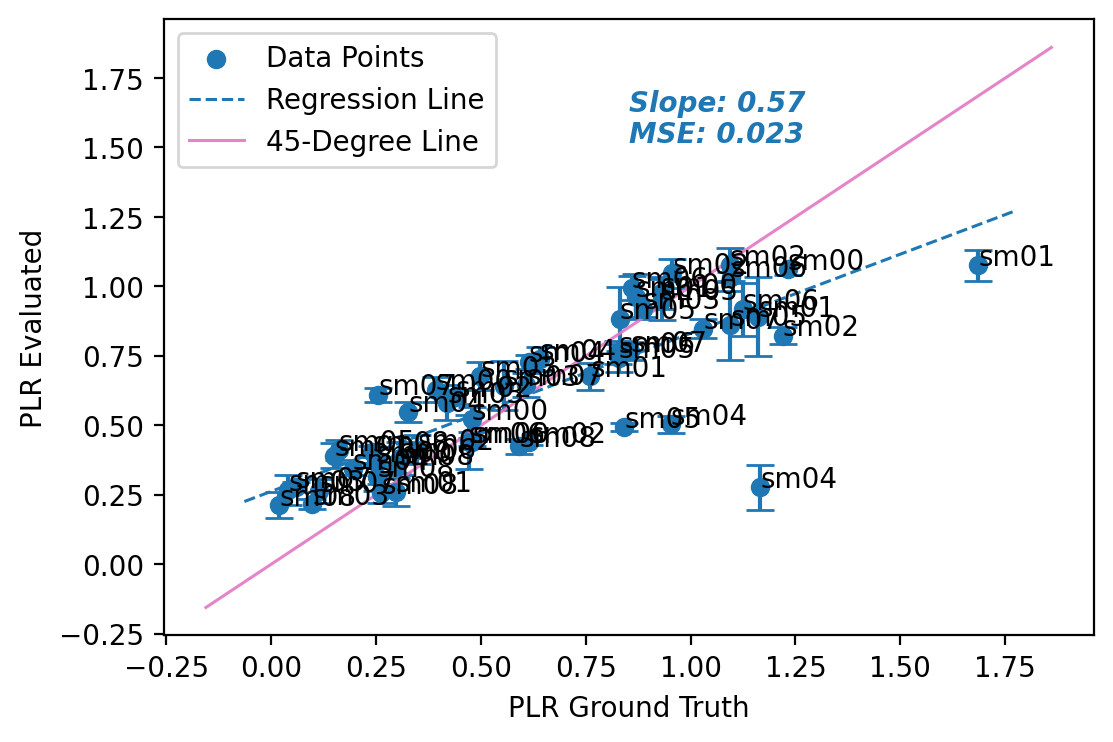

In [22]:
eval = Eval(filepaths, model_name='BR')
eval.hist_method_all()
eval.plot()

# A Eval

In [23]:
# Single Radio Example
dates = data_loader(query_dates=True)

selected_dates = [s for s in dates if s >= '2023-09-12']
# excluded_dates = []
# selected_exps = []
# excluded_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
selected_routes = ['A']
# excluded_routes = []
filepaths = data_loader(mode='sr', selected_dates=selected_dates, selected_routes=selected_routes)

# print(len(filepaths))
# pprint(filepaths)

  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.8882208139198076
Standard Deviation: 0.05425633741245463
Ground Truth: 1.6379561519907104


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 2.2424443925927258
Standard Deviation: 0.07500925369618781
Ground Truth: 2.3746092958736003


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 2.1797479460796043
Standard Deviation: 0.04101682406798107
Ground Truth: 2.217037568796363
******** Empty RRC Data ********


  0%|                                                                                                         …


Mean: 1.2648037271394155
Standard Deviation: 0.032933457242587526
Ground Truth: 0.9734397834195736


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 2.337270742378743
Standard Deviation: 0.11529370611528748
Ground Truth: 2.744135292163575


  0%|                                                                                                         …


Mean: 2.4057269687164933
Standard Deviation: 0.19723278800272656
Ground Truth: 2.562141346596212


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.6322174289376121
Standard Deviation: 0.10019764340902107
Ground Truth: 1.3897898624867375


  0%|                                                                                                         …


Mean: 1.6244278949668434
Standard Deviation: 0.11555597154145682
Ground Truth: 0.44073382138529044


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 2.040284941024604
Standard Deviation: 0.14136397247278681
Ground Truth: 1.5684648077140004


  0%|                                                                                                         …


Mean: 2.0958196243491316
Standard Deviation: 0.10250002771757755
Ground Truth: 1.8816136585944214


  0%|                                                                                                         …


Mean: 1.7337401539396307
Standard Deviation: 0.3634222120444903
Ground Truth: 2.0673710717207765


  0%|                                                                                                         …


Mean: 1.7908883711271966
Standard Deviation: 0.02134858041645214
Ground Truth: 6.382264672485946


  0%|                                                                                                         …


Mean: 1.4299171843648246
Standard Deviation: 0.11711834272839798
Ground Truth: 1.0299646232896194


  0%|                                                                                                         …


Mean: 2.3303880027566617
Standard Deviation: 0.01596140621992792
Ground Truth: 2.299205232416455


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.8819621327349474
Standard Deviation: 0.05207061797280019
Ground Truth: 1.8903402284197095


  0%|                                                                                                         …


Mean: 1.6193552804151272
Standard Deviation: 0.05934446232399365
Ground Truth: 1.738552651131886


  0%|                                                                                                         …


Mean: 1.7244625716220652
Standard Deviation: 0.14645431351255964
Ground Truth: 0.44681836697880156


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 2.316708880975806
Standard Deviation: 0.05530304063494105
Ground Truth: 2.74148794391893


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 2.542443906172073
Standard Deviation: 0.09419720455959492
Ground Truth: 2.2319373821002606


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.7933864333984708
Standard Deviation: 0.08905548093126185
Ground Truth: 1.3810003620166706


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.5162472340396382
Standard Deviation: 0.08291128297217526
Ground Truth: 3.6874833014776907


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.2901753243263439
Standard Deviation: 0.06595577047010436
Ground Truth: 0.603484989314558


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.6740099423242432
Standard Deviation: 0.036499909069313496
Ground Truth: 0.9581369060617348


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.8764130164322115
Standard Deviation: 0.0761916113585895
Ground Truth: 1.578252898196007


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.5682374737577829
Standard Deviation: 0.011225361003593153
Ground Truth: 0.9718292849011854


  0%|                                                                                                         …


Mean: 1.3669740190363633
Standard Deviation: 0.03501144296119629
Ground Truth: 0.5094277208071452


  0%|                                                                                                         …


Mean: 1.7266577413118502
Standard Deviation: 0.008451239446426326
Ground Truth: 1.4311977197974024


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.7026895178921013
Standard Deviation: 0.051503953943344324
Ground Truth: 1.236207614067443


  0%|                                                                                                         …


Mean: 1.6464970462299167
Standard Deviation: 0.06769347856844635
Ground Truth: 1.1670469550787477


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.4178516181986123
Standard Deviation: 0.05747581285837866
Ground Truth: 3.495177440707094


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.3816108346507845
Standard Deviation: 0.08139202632423158
Ground Truth: 0.7262687498889788


  0%|                                                                                                         …


Mean: 1.708076908580874
Standard Deviation: 0.07331964150042905
Ground Truth: 1.166938571128592


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.751281102512447
Standard Deviation: 0.1310436859819943
Ground Truth: 1.2368160557117511


  0%|                                                                                                         …


Mean: 1.5099476011566235
Standard Deviation: 0.06649578041477858
Ground Truth: 0.7457934102293791


  0%|                                                                                                         …


Mean: 1.3444118061300996
Standard Deviation: 0.23528094299286034
Ground Truth: 0.4749001242280027


  0%|                                                                                                         …


Mean: 1.3223073211466096
Standard Deviation: 0.08756770755868445
Ground Truth: 0.622930101864757


  0%|                                                                                                         …


Mean: 1.1347805550323915
Standard Deviation: 0.04355986112907982
Ground Truth: 0.6658012035766495


  0%|                                                                                                         …


Mean: 1.0656755353331666
Standard Deviation: 0.051687945561295696
Ground Truth: 0.5200523529088501


  0%|                                                                                                         …


Mean: 1.086418978964722
Standard Deviation: 0.13263354108862088
Ground Truth: 0.6217759300045796
******** Empty RRC Data ********
******** Empty RRC Data ********


  0%|                                                                                                         …


Mean: 0.9485866059571239
Standard Deviation: 0.3540842448864829
Ground Truth: 0.04580979219012452
******** Empty RRC Data ********


  0%|                                                                                                         …


Mean: 0.9116709300645537
Standard Deviation: 0.09543785900036898
Ground Truth: 0.19763600388983588


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 2.23048502524216
Standard Deviation: 0.06677627581832056
Ground Truth: 2.760555124931417


  0%|                                                                                                         …


Mean: 2.4198975274670365
Standard Deviation: 0.1897821158017852
Ground Truth: 3.552642099021247


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 2.3147623837788984
Standard Deviation: 0.03293734565648668
Ground Truth: 3.401611495646497


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 2.121055512233797
Standard Deviation: 0.017540780441616922
Ground Truth: 6.178330114022685


  0%|                                                                                                         …

Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!
Overlapping event occurs!!

Mean: 1.7348516893876063
St

  0%|                                                                                                         …


Mean: 1.9222570341614693
Standard Deviation: 0.12687087857321272
Ground Truth: 2.9138841386541507


  0%|                                                                                                         …


Mean: 2.4519240550457404
Standard Deviation: 0.10812747621781996
Ground Truth: 2.531956694946149


  0%|                                                                                                         …


Mean: 1.5912913865825589
Standard Deviation: 0.15887350176334258
Ground Truth: 1.4710818277294302


  0%|                                                                                                         …


Mean: 1.8441259598309196
Standard Deviation: 0.17298517277211922
Ground Truth: 3.251294364823291


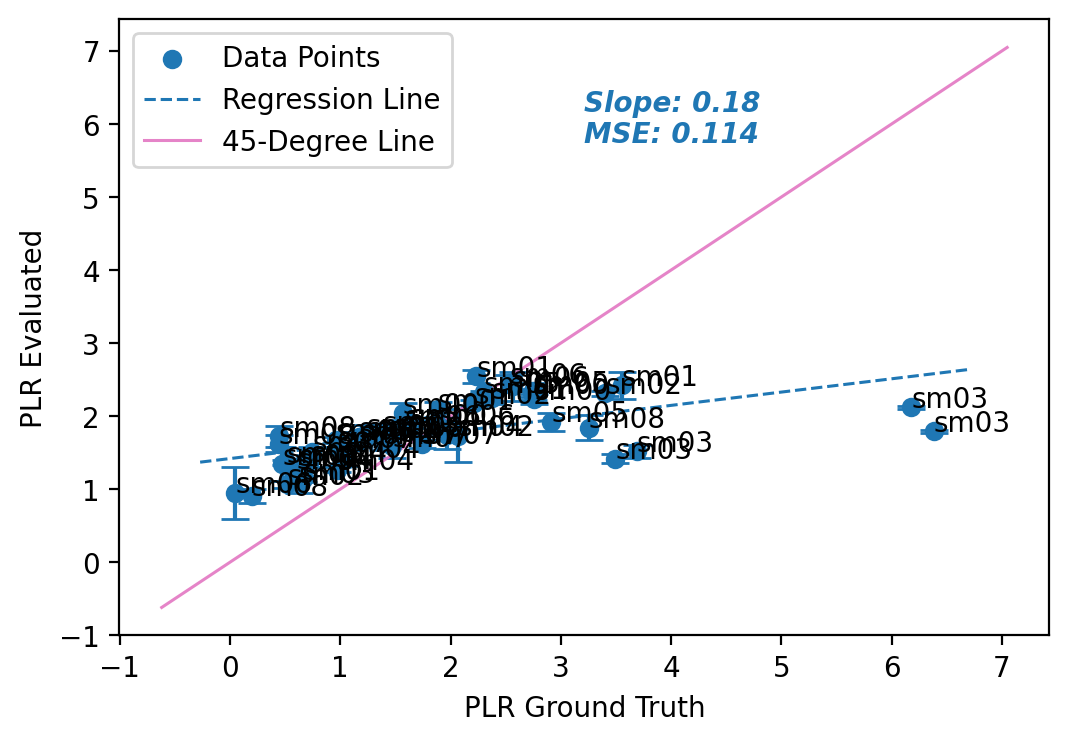

In [24]:
eval = Eval(filepaths, model_name='A')
eval.hist_method_all()
eval.plot()